In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np
from utility import *
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
import random
random.seed(2)

## Basic univariate data inspection

In [3]:
df_raw = pd.read_csv('data/raw/BankChurners.csv')
df_raw.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count   
0  768805383  Existing Customer            45      M                3  \
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category   
0     High School        Married     $60K - $80K          Blue  \
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy   
0              39  ...       12691.0                  777          11914.0  \
1              44  ...        8256.0                  864           7392.0   
2              36  ...        3418.0                    0           3418.0   
3              34  ...        3313.0                 2517            796.0   
4              21  ...        4716.0                    0           4716.0   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1   
0                 1.335             1144              42                1.625  \
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 1.405             1171              20                2.333   
4                 2.175              816              28                2.500   

   Avg_Utilization_Ratio   
0                  0.061  \
1                  0.105   
2                  0.000   
3                  0.760   
4                  0.000   

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1   
0                                           0.000093                                                                                   \
1                                           0.000057                                                                                    
2                                           0.000021                                                                                    
3                                           0.000134                                                                                    
4                                           0.000022                                                                                    

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2  
0                                            0.99991                                                                                   
1                                            0.99994                                                                                   
2                                            0.99998                                                                                   
3                                            0.99987                                                                                   
4                                            0.99998                                                                                   

[5 rows x 23 columns]

We can see that the two last columns in the dataset are irrelevant, they were probably added when someone was trying to do classification using Naive Bayes. We can drop these.
Also, there is no need for the CLIENTNUM identificators (that were internal to the bank from which the data are collected). We will instead use simple id column as identifier.

In [4]:
# dropping irrelevant columns
df = df_raw.drop(axis='columns',columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', 'CLIENTNUM'])

In [5]:
df['id'] = np.arange(df.shape[0])
first_col = df.pop('id')
df.insert(0, 'id', first_col)

In [6]:
df.dtypes

id                            int32
Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

In [7]:
df.dtypes.value_counts()

int64      9
object     6
float64    5
int32      1
Name: count, dtype: int64

The dataset contains 15 numerical and 6 categorical variables

In [8]:
print('Dataset - rows:', df.shape[0], ' columns:', df.shape[1])


Dataset - rows: 10127  columns: 21


In [9]:
df.describe()

id  Customer_Age  Dependent_count  Months_on_book   
count  10127.000000  10127.000000     10127.000000    10127.000000  \
mean    5063.000000     46.325960         2.346203       35.928409   
std     2923.557422      8.016814         1.298908        7.986416   
min        0.000000     26.000000         0.000000       13.000000   
25%     2531.500000     41.000000         1.000000       31.000000   
50%     5063.000000     46.000000         2.000000       36.000000   
75%     7594.500000     52.000000         3.000000       40.000000   
max    10126.000000     73.000000         5.000000       56.000000   

       Total_Relationship_Count  Months_Inactive_12_mon   
count              10127.000000            10127.000000  \
mean                   3.812580                2.341167   
std                    1.554408                1.010622   
min                    1.000000                0.000000   
25%                    3.000000                2.000000   
50%                    4.000000                2.000000   
75%                    5.000000                3.000000   
max                    6.000000                6.000000   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal   
count           10127.000000  10127.000000         10127.000000  \
mean                2.455317   8631.953698          1162.814061   
std                 1.106225   9088.776650           814.987335   
min                 0.000000   1438.300000             0.000000   
25%                 2.000000   2555.000000           359.000000   
50%                 2.000000   4549.000000          1276.000000   
75%                 3.000000  11067.500000          1784.000000   
max                 6.000000  34516.000000          2517.000000   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct   
count     10127.000000          10127.000000     10127.000000    10127.000000  \
mean       7469.139637              0.759941      4404.086304       64.858695   
std        9090.685324              0.219207      3397.129254       23.472570   
min           3.000000              0.000000       510.000000       10.000000   
25%        1324.500000              0.631000      2155.500000       45.000000   
50%        3474.000000              0.736000      3899.000000       67.000000   
75%        9859.000000              0.859000      4741.000000       81.000000   
max       34516.000000              3.397000     18484.000000      139.000000   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
count         10127.000000           10127.000000  
mean              0.712222               0.274894  
std               0.238086               0.275691  
min               0.000000               0.000000  
25%               0.582000               0.023000  
50%               0.702000               0.176000  
75%               0.818000               0.503000  
max               3.714000               0.999000

In order to understand our data, we can look at each variable and try to understand their meaning and relevance to this problem.

In [10]:
df['Attrition_Flag'].value_counts()


Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64

In [11]:
def visualize_distribution(df, column):
    # Initialise the subplot function using number of rows and columns
    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(15, 5))
    fig.suptitle(column)
    ax[0].boxplot(df[column], vert=False)
    ax[1].hist(df[column], bins=(round(1 + 3.322 * math.log(len(df[column]), 10)))) # bins amount chosen by Sturge's rule
    fig.tight_layout()

def visualize_distribution_compact(df, numerical_columns):
    plt.figure(figsize=(28,40))
    b = 0
    for i in numerical_columns:
        b+=1
        plt.subplot(5,3,b)
        plt.hist(df[i])
        plt.title(i)


def visualize_distribution_cat(df, column):
    fig, ax = plt.subplots(1, tight_layout=True, figsize=(15, 5))
    fig.suptitle(column)
    df[column].value_counts(sort=False).plot(kind="bar", ax=ax, rot=0)



In [12]:
numerical_columns = df._get_numeric_data().columns.to_list()
categorical_columns = list(set(df.columns) - set(numerical_columns))
numerical_columns.remove('id')
categorical_columns_indices = [df.columns.get_loc(c) for c in categorical_columns if c in df]
numerical_columns_indices = [df.columns.get_loc(c) for c in numerical_columns if c in df]


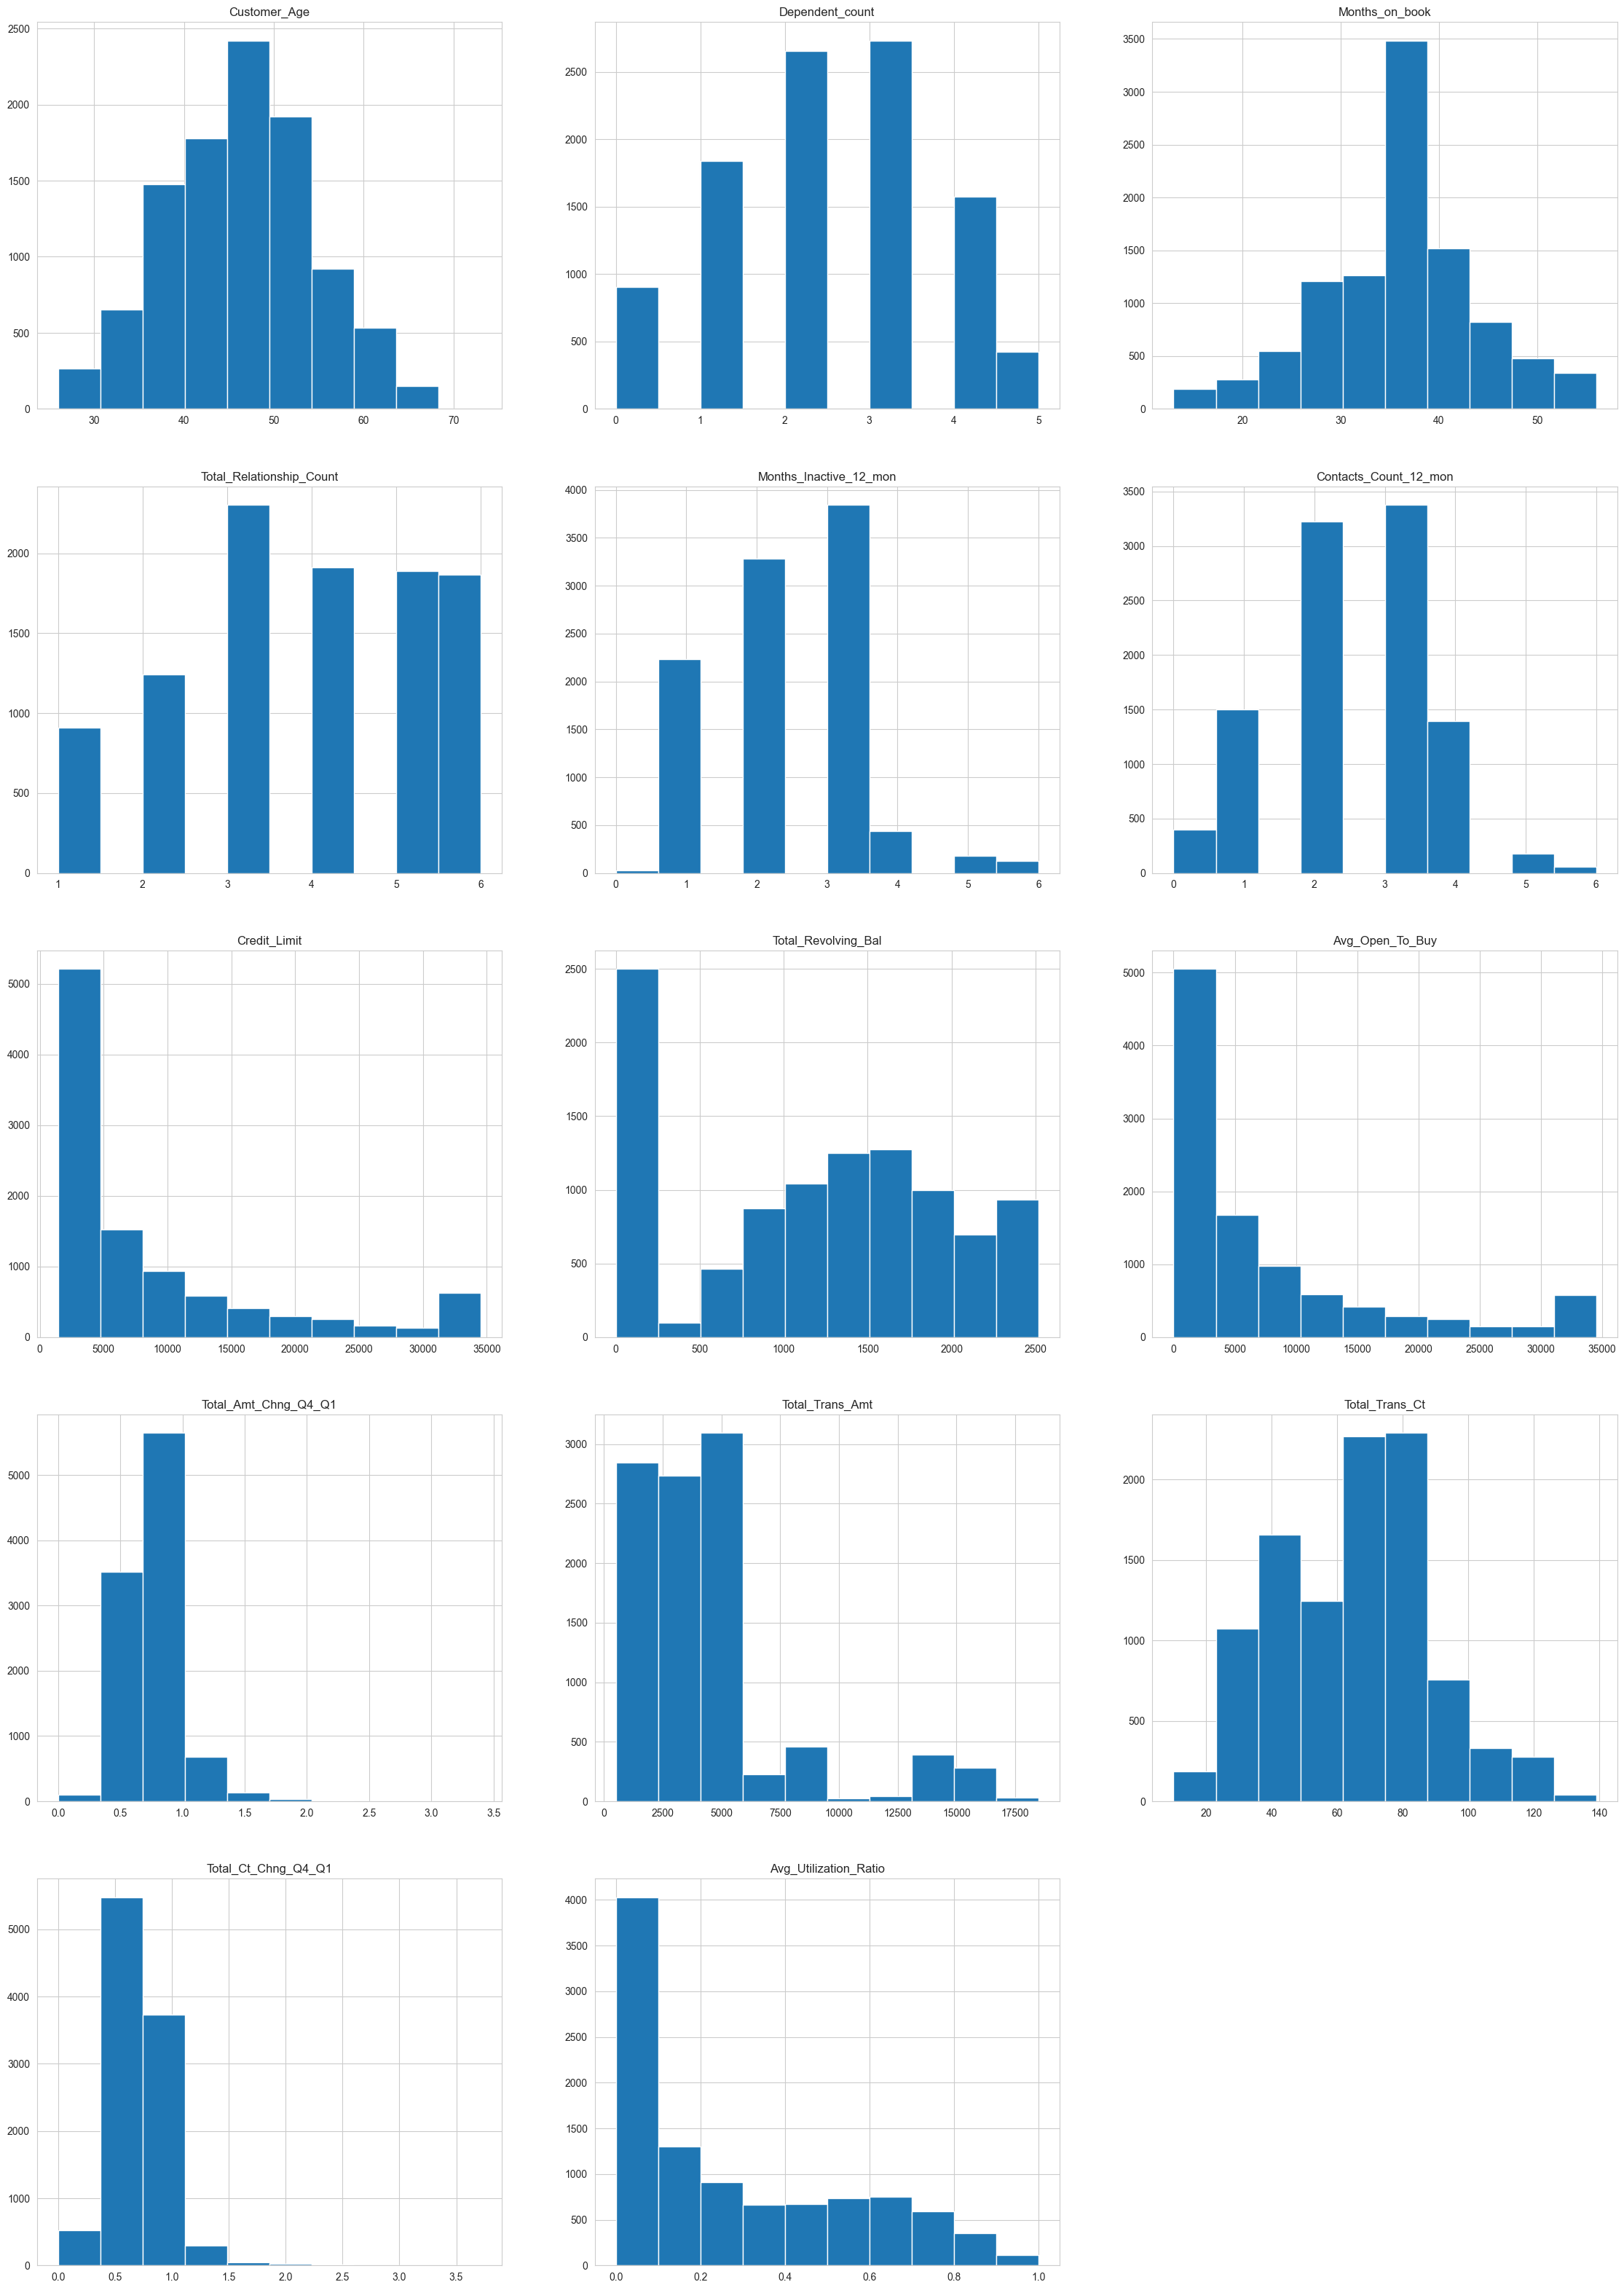

In [13]:
visualize_distribution_compact(df, numerical_columns)

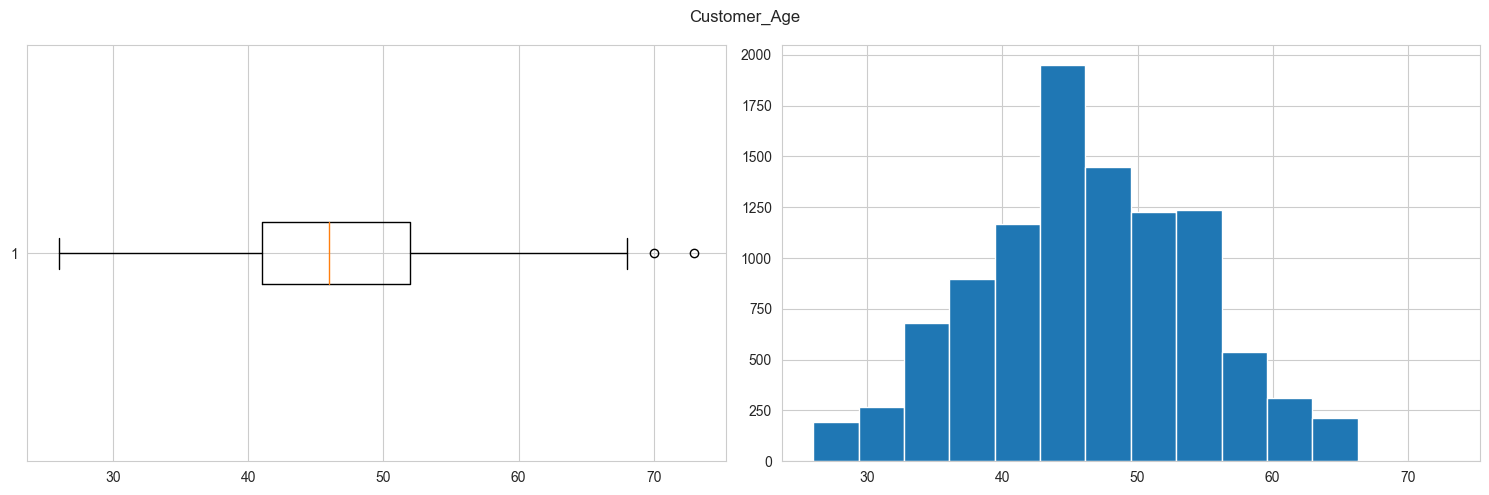

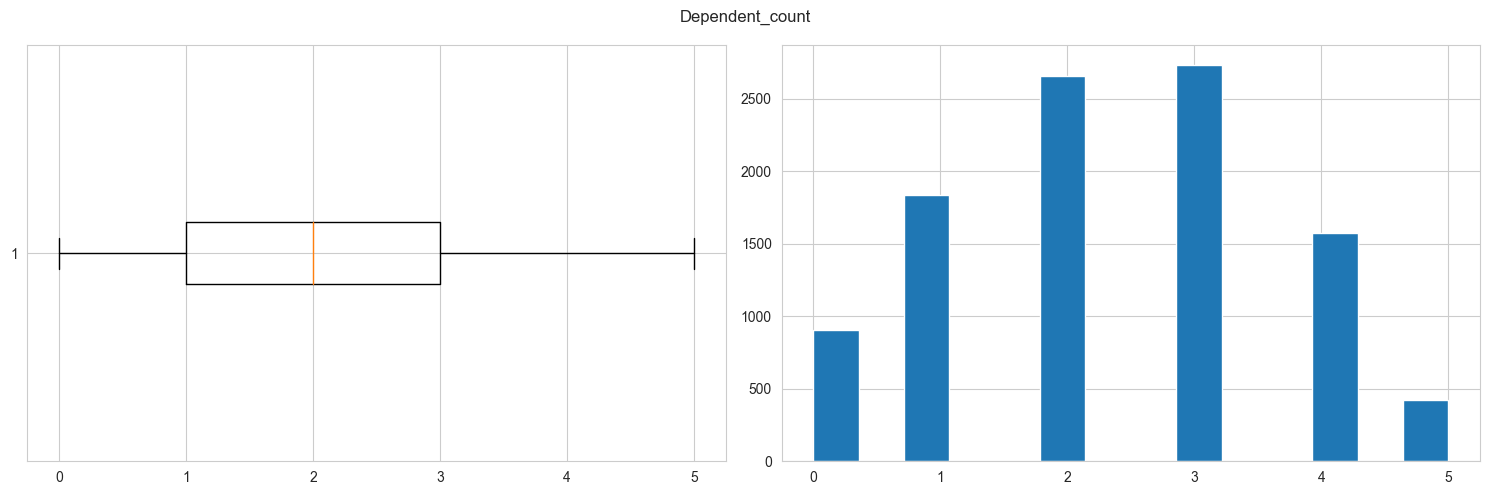

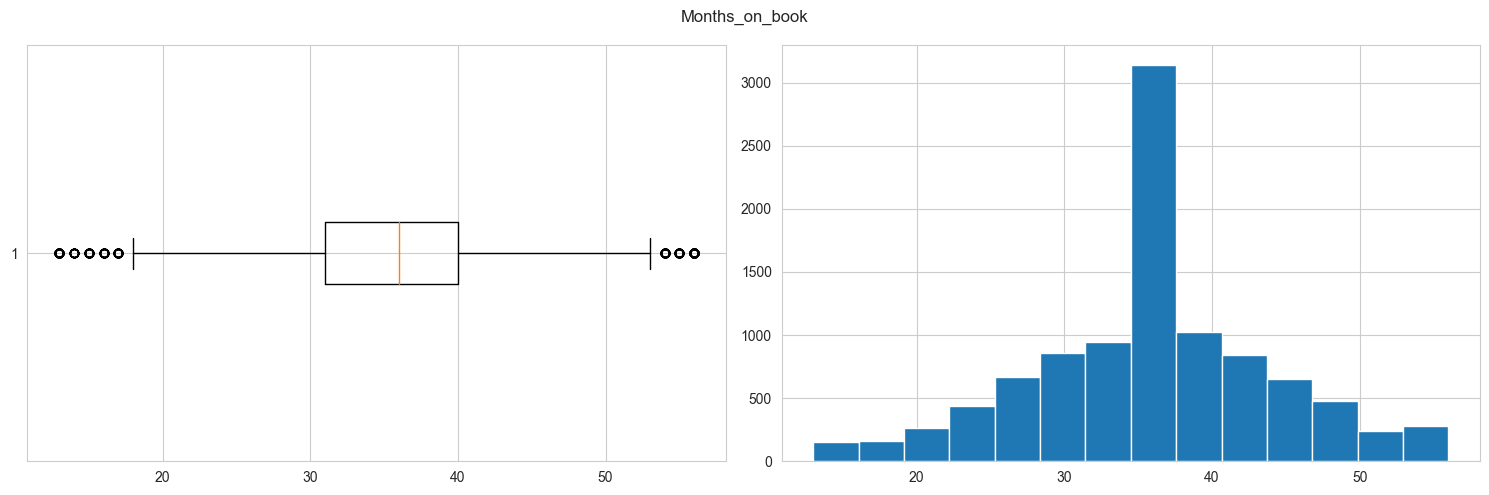

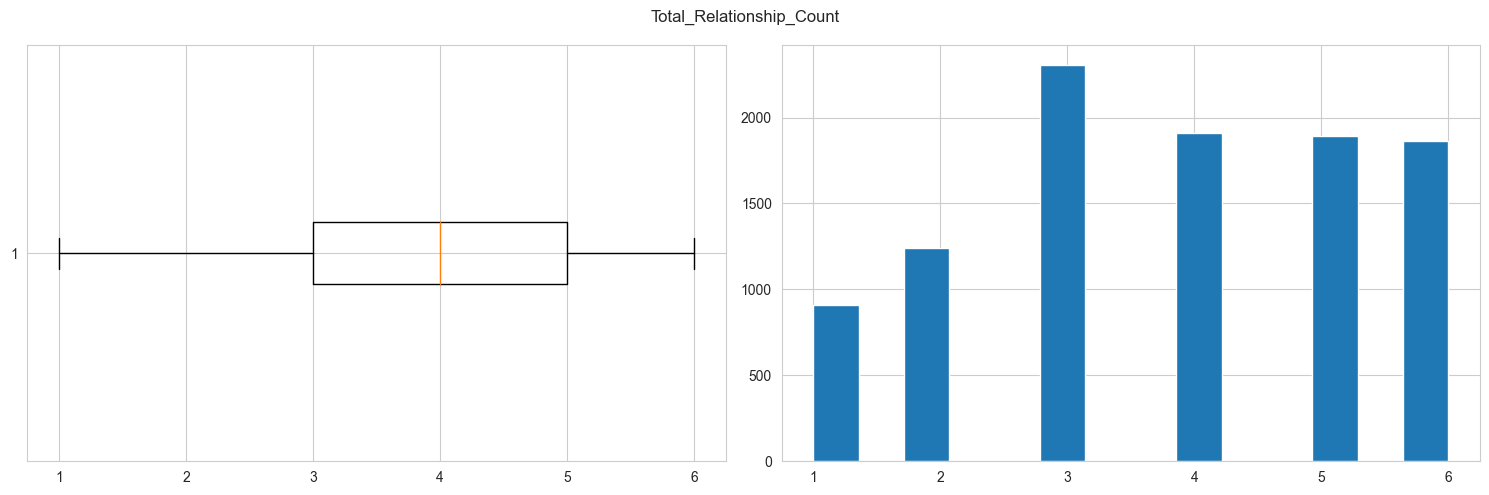

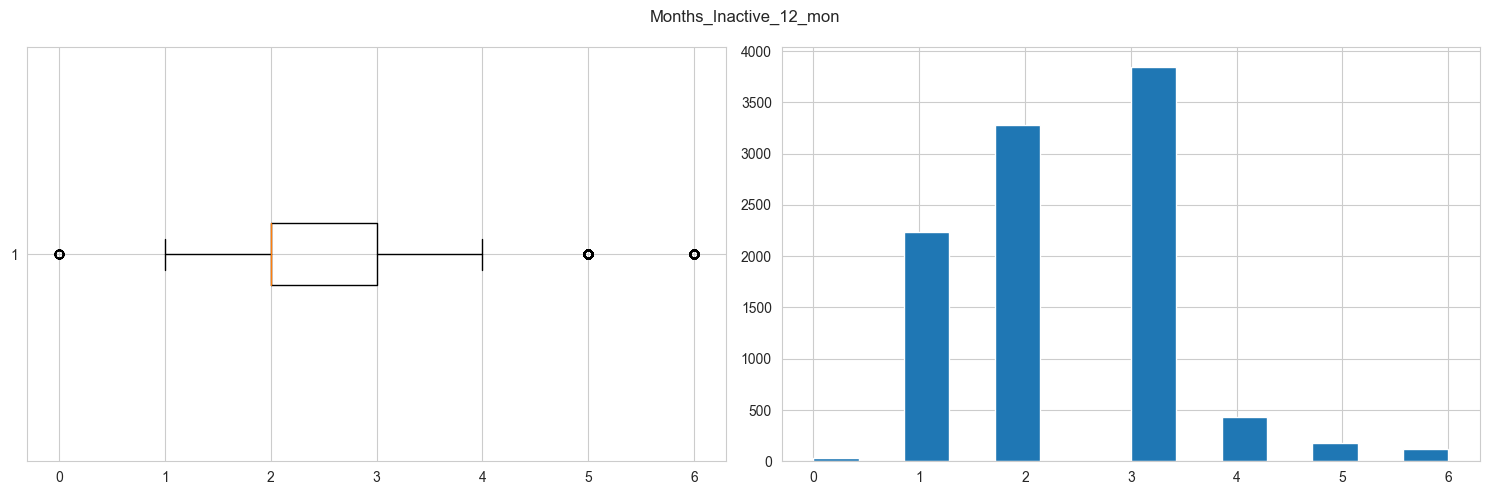

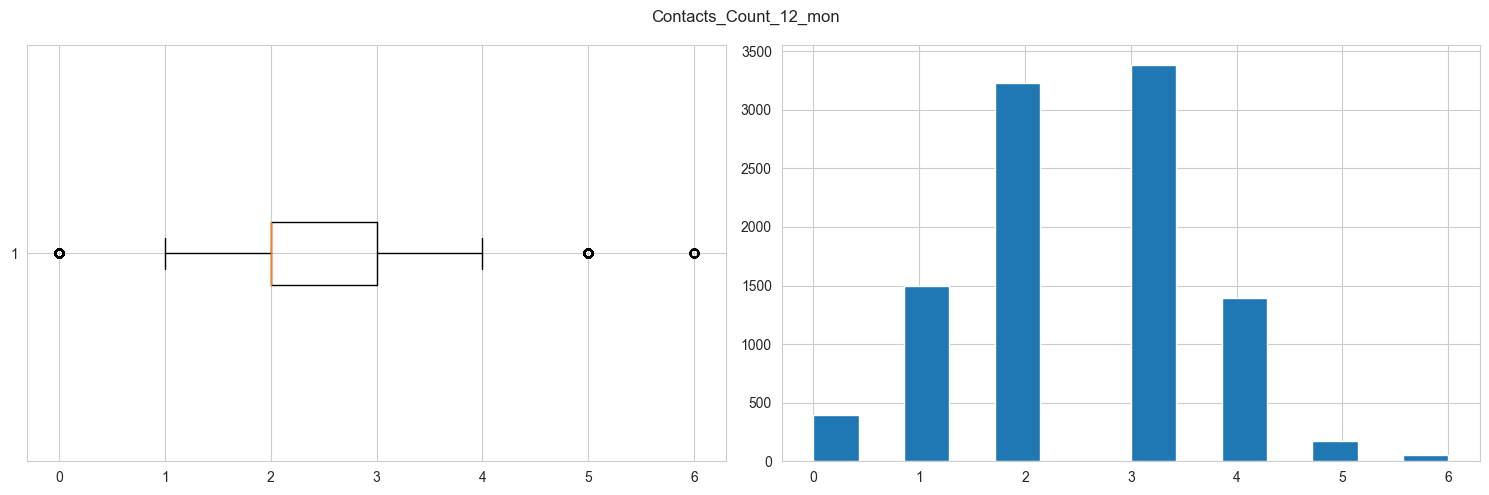

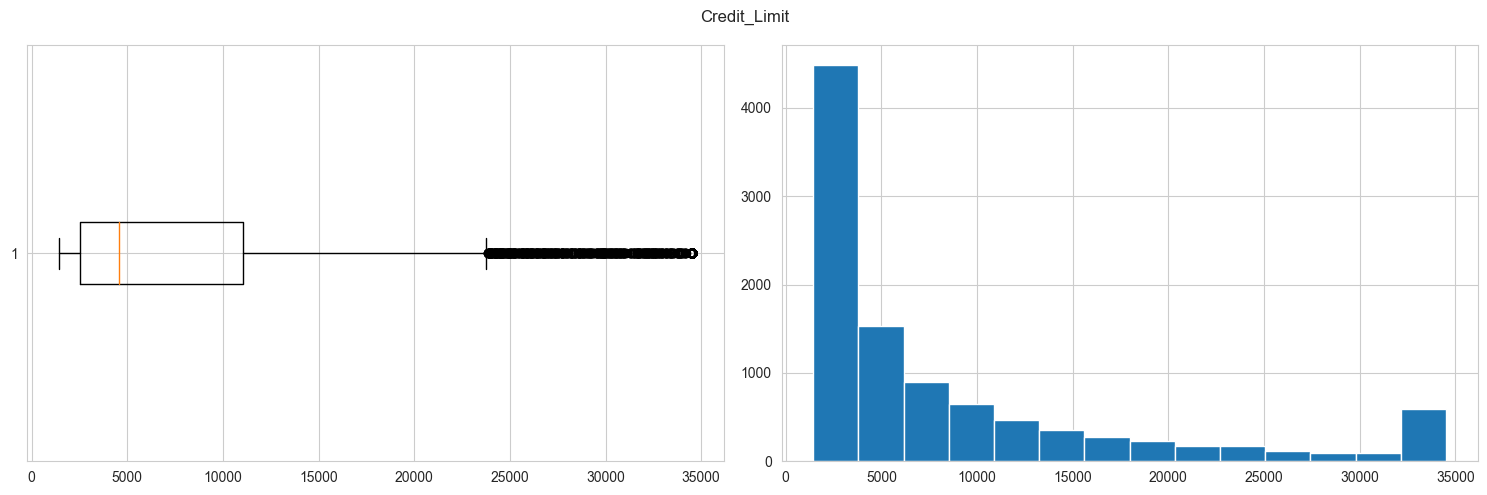

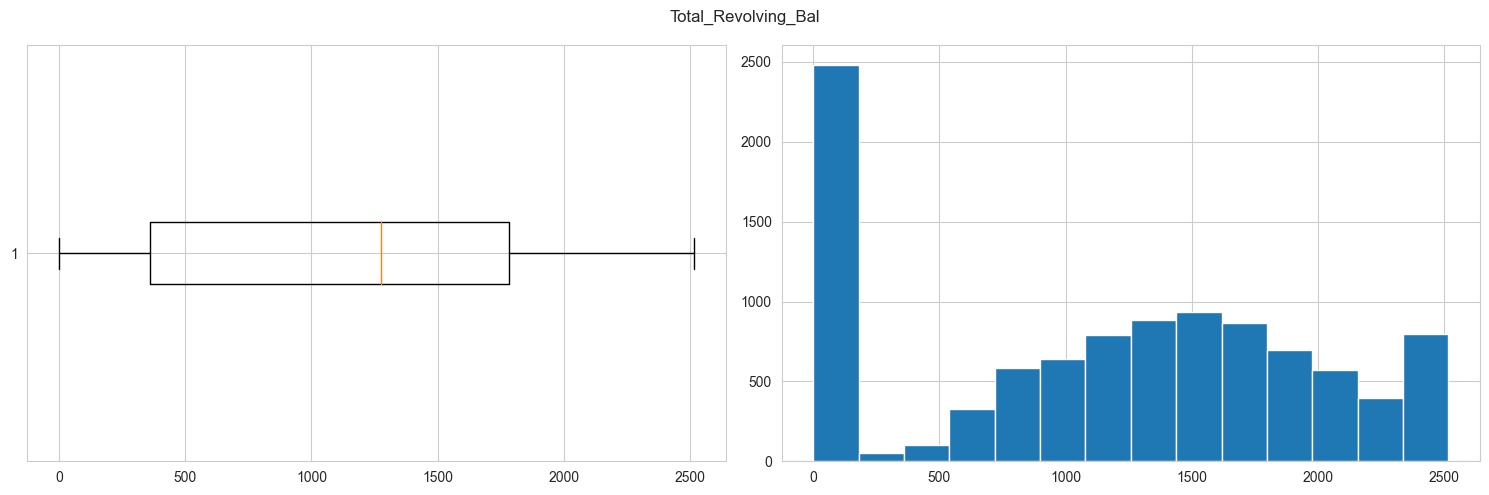

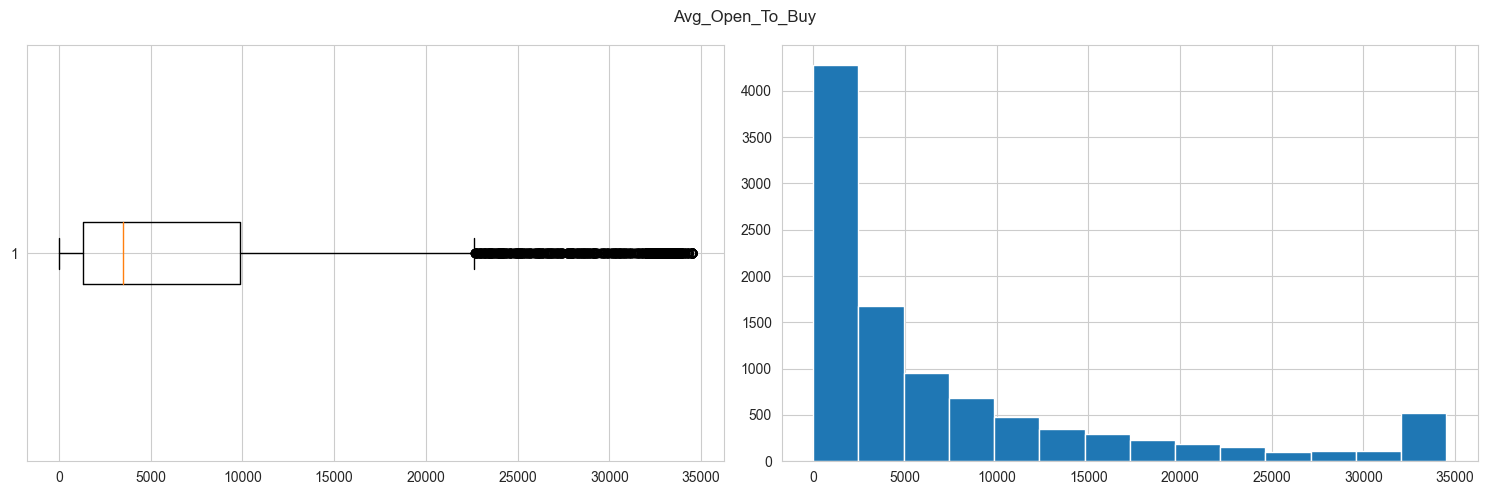

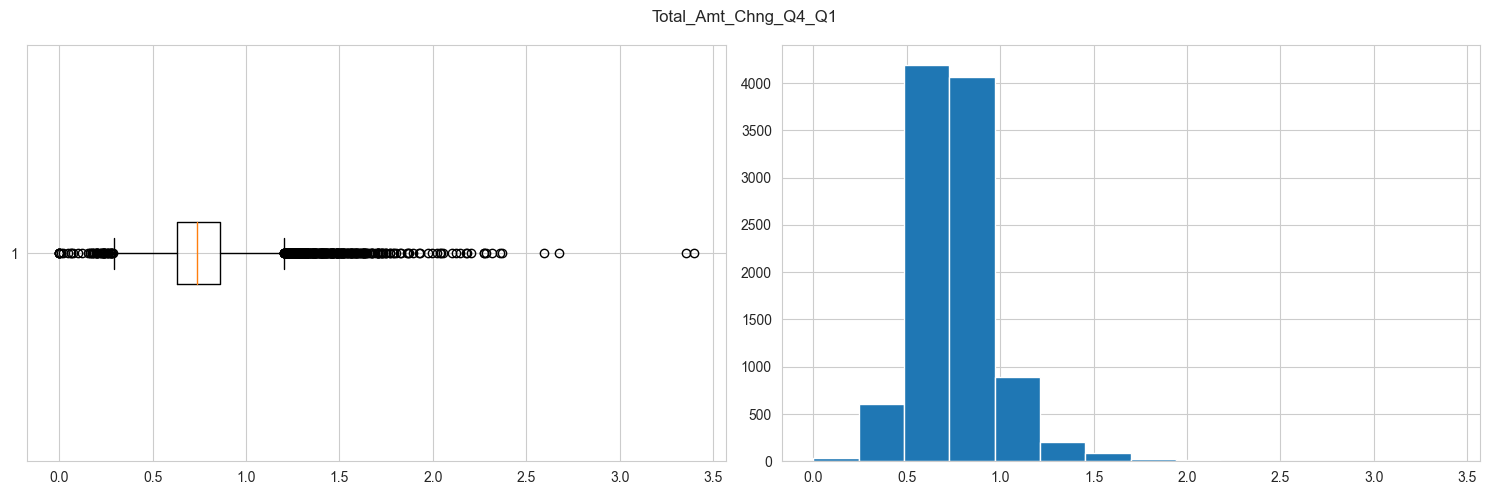

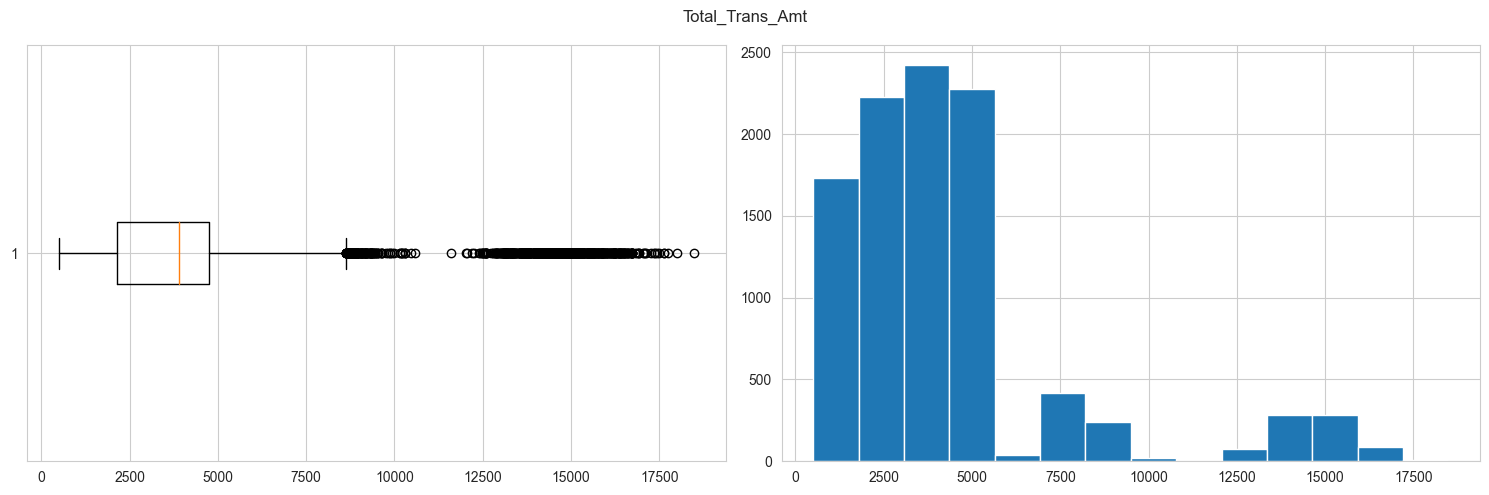

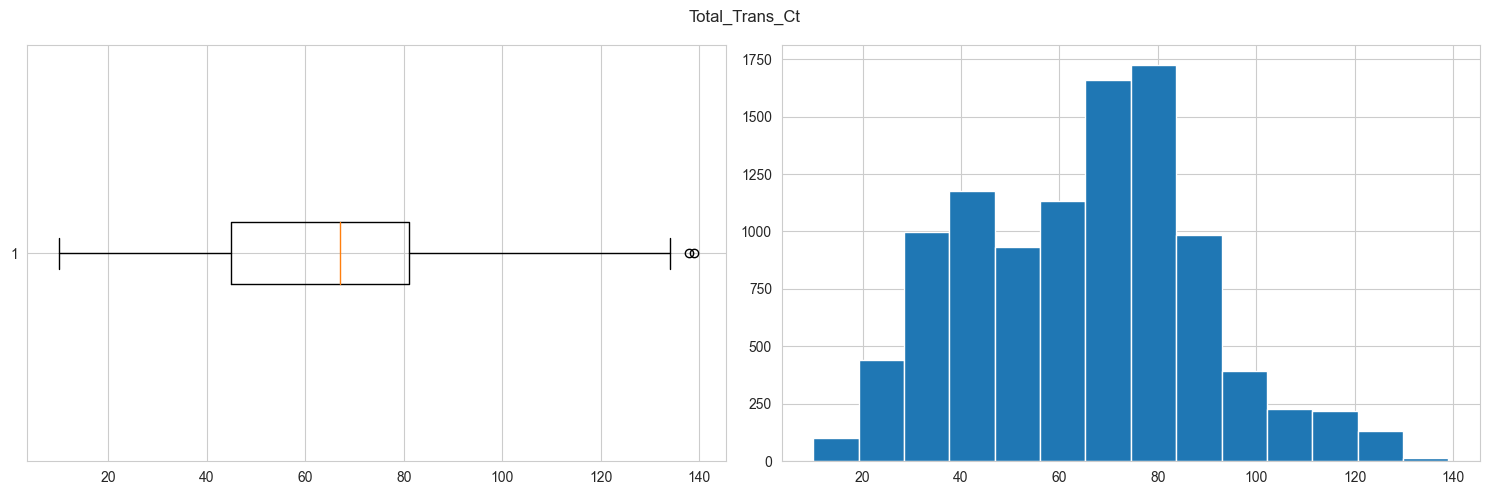

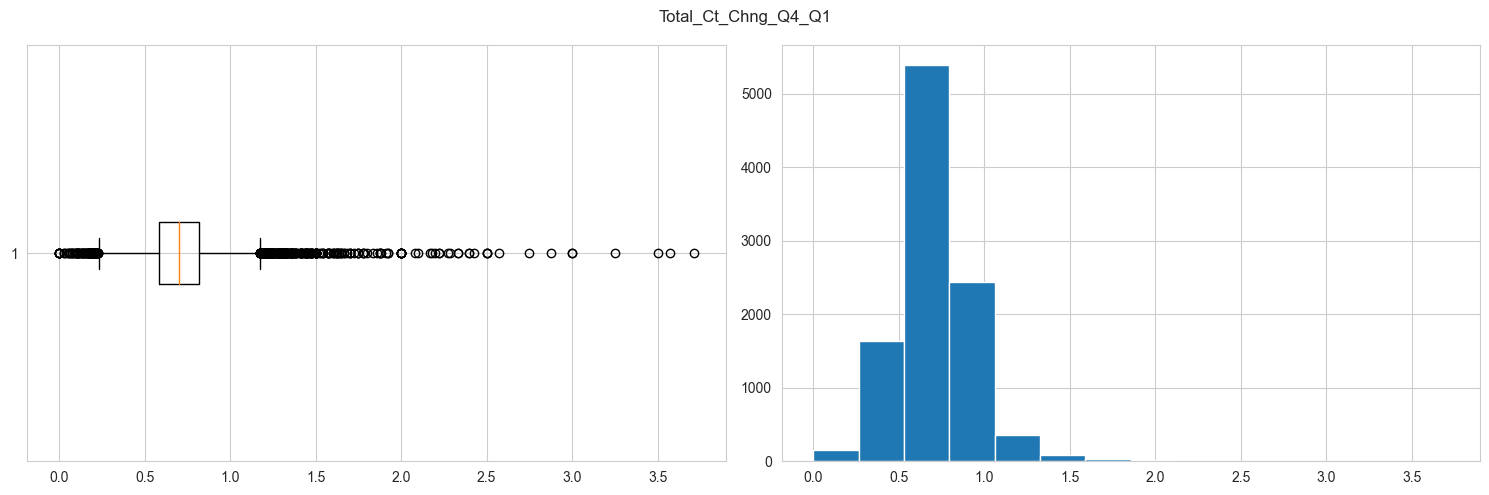

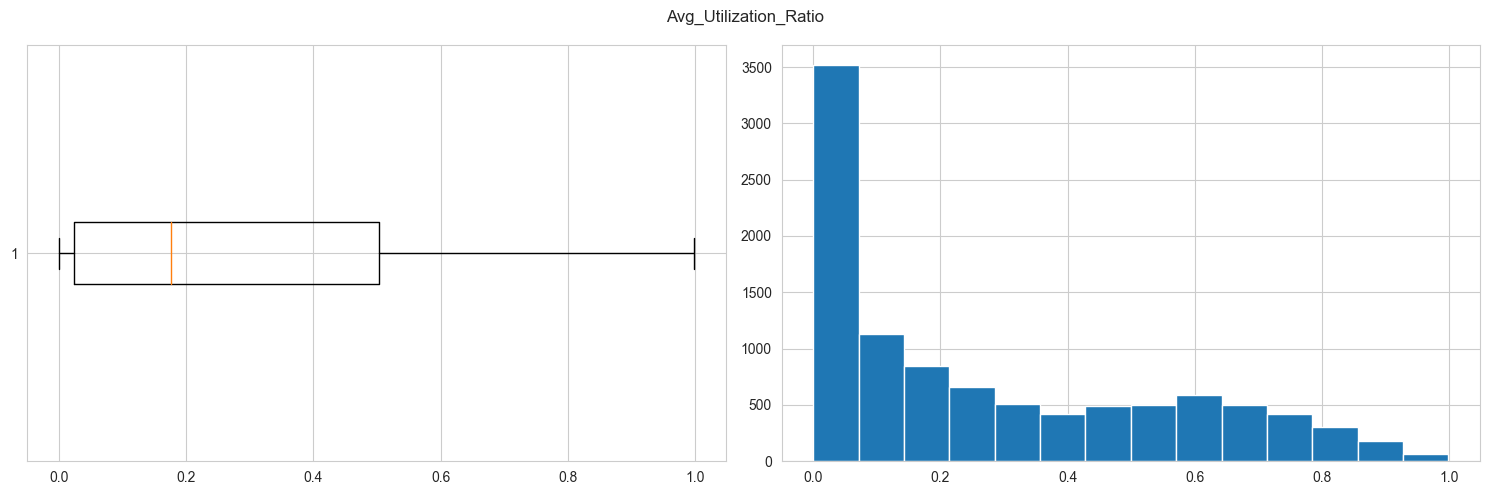

In [14]:
for column in numerical_columns:
    visualize_distribution(df, column)

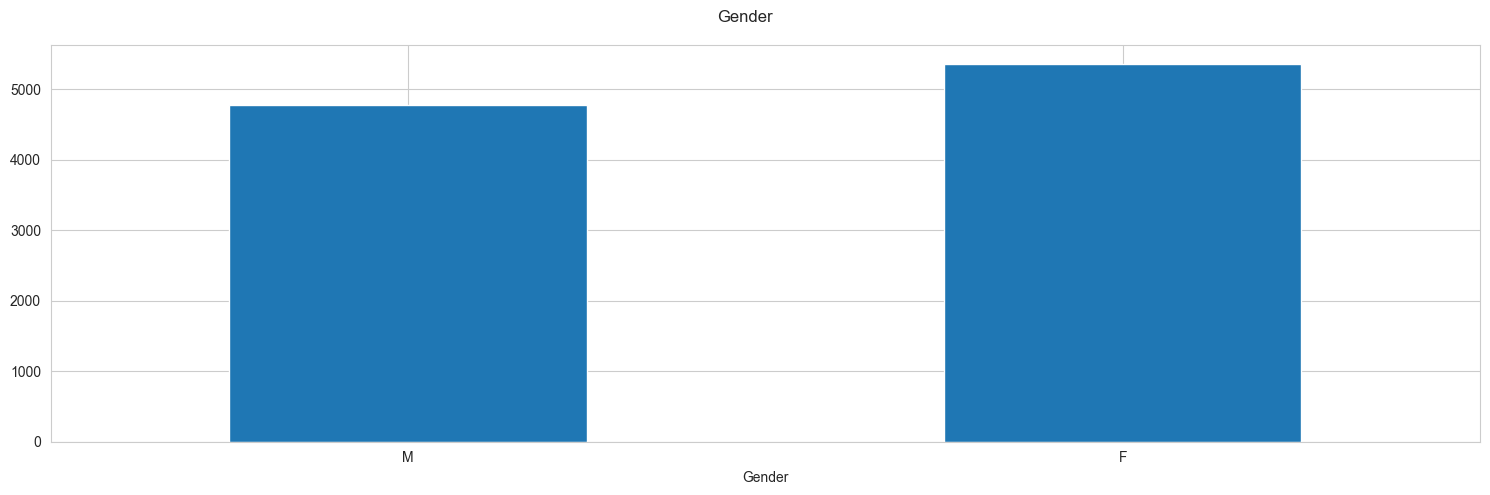

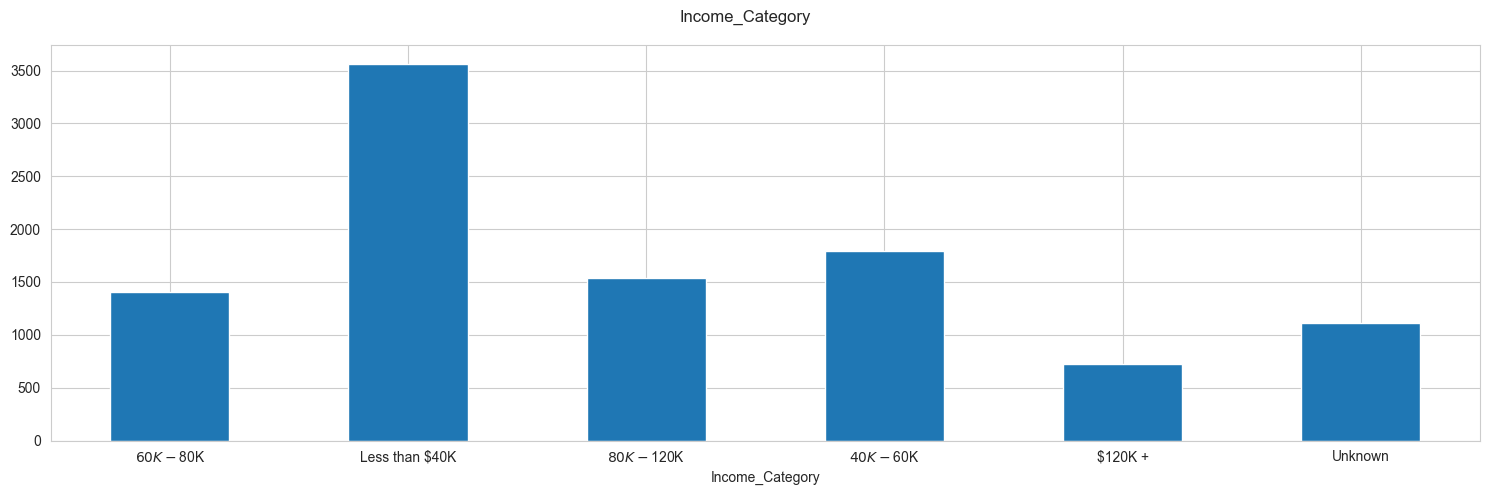

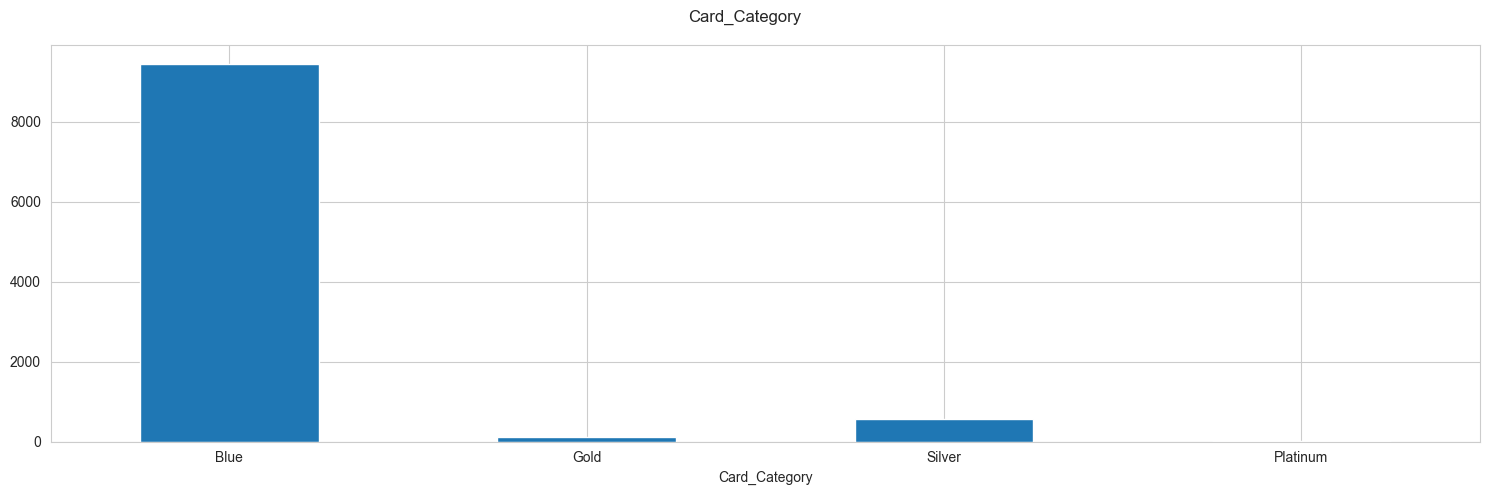

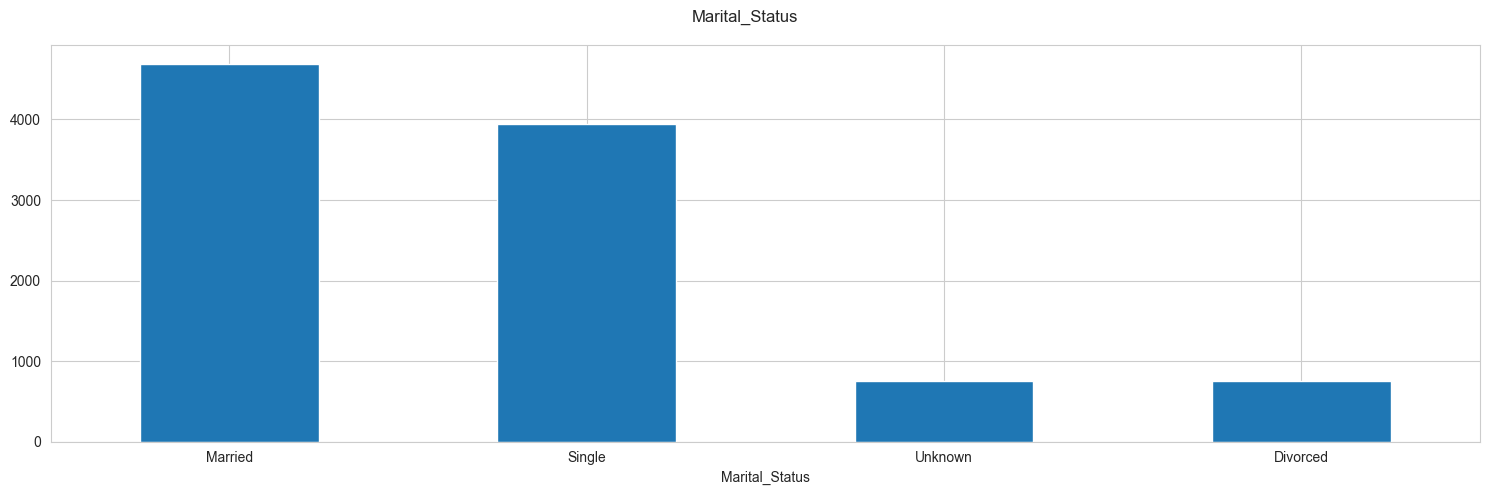

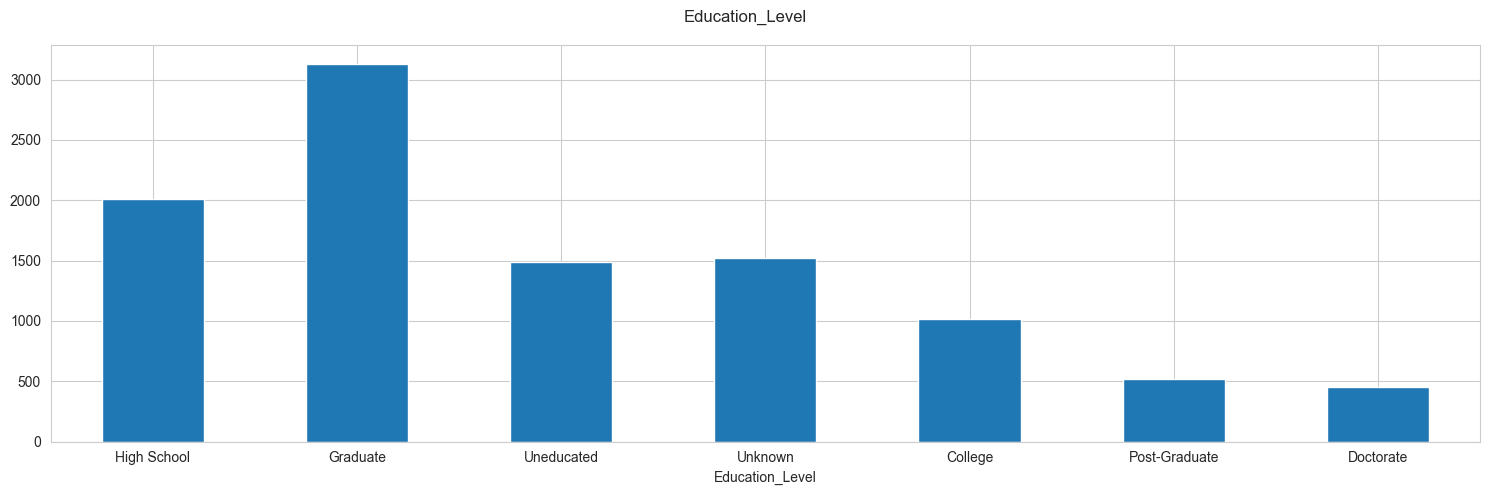

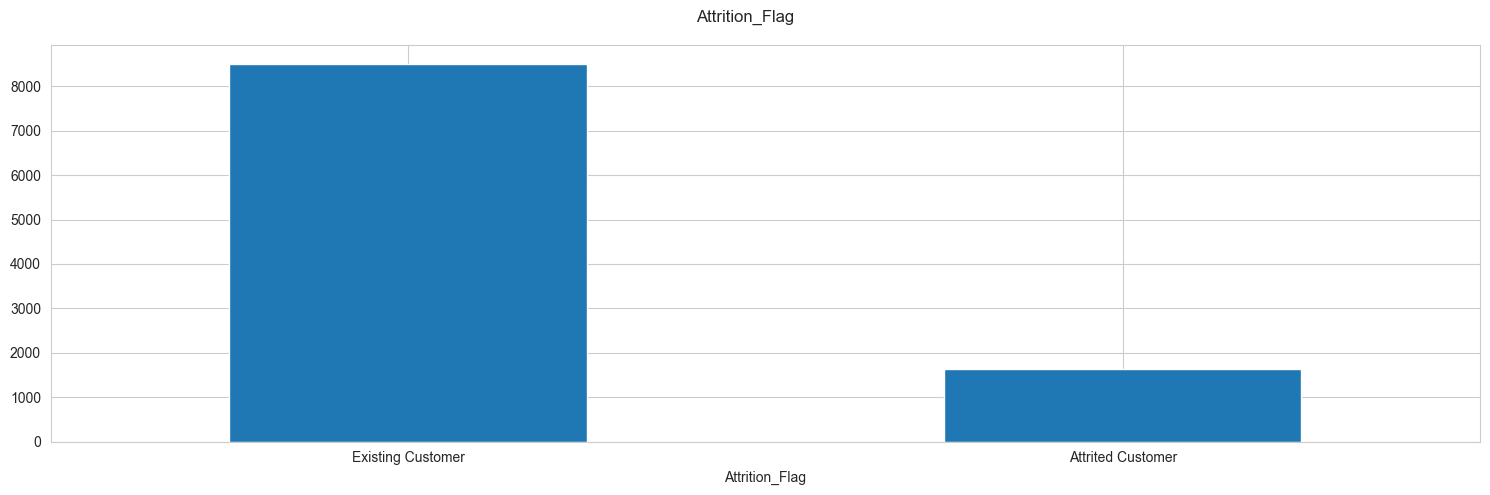

In [15]:
for column in categorical_columns:
    visualize_distribution_cat(df, column)

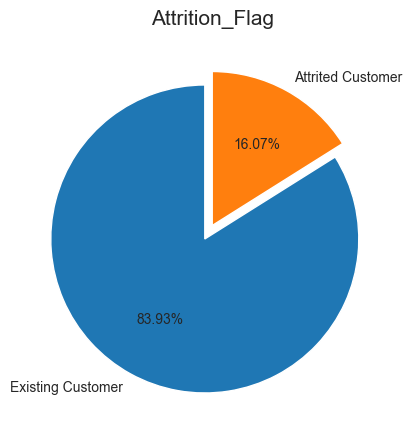

In [16]:
fig,ax = plt.subplots(figsize=(7,5))
attr_count = df['Attrition_Flag'].value_counts()
attr_label = df['Attrition_Flag'].value_counts().index
ax.pie(attr_count, explode=(0.1,0), labels=attr_label, autopct='%.2f%%', startangle=90)
ax.set_title('Attrition_Flag', fontsize=15)
plt.show()

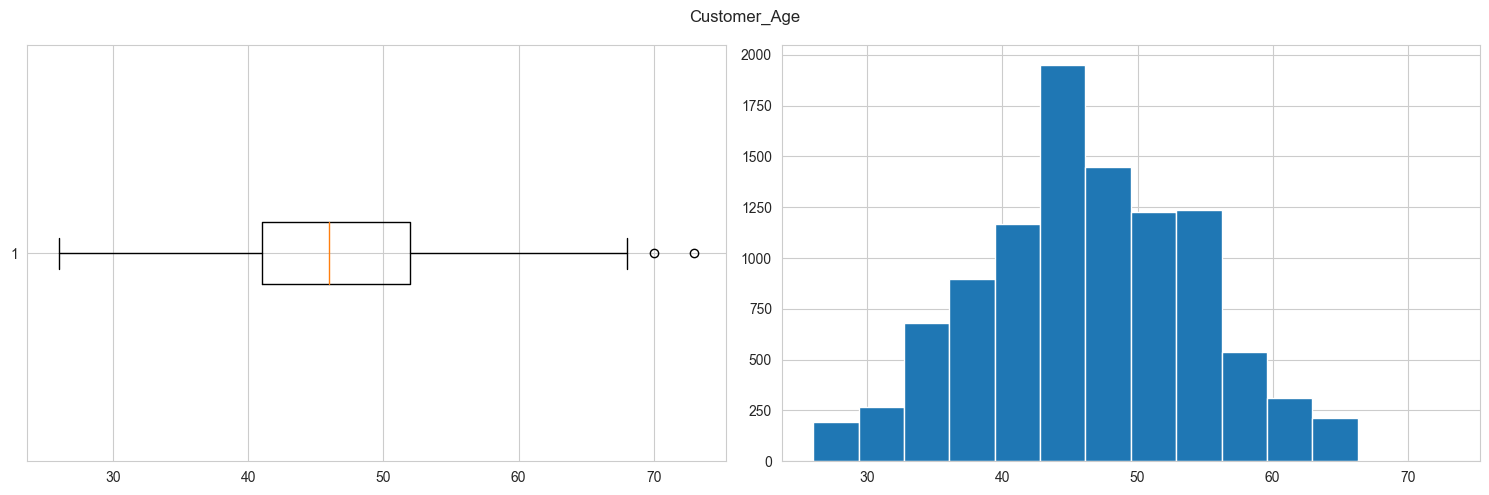

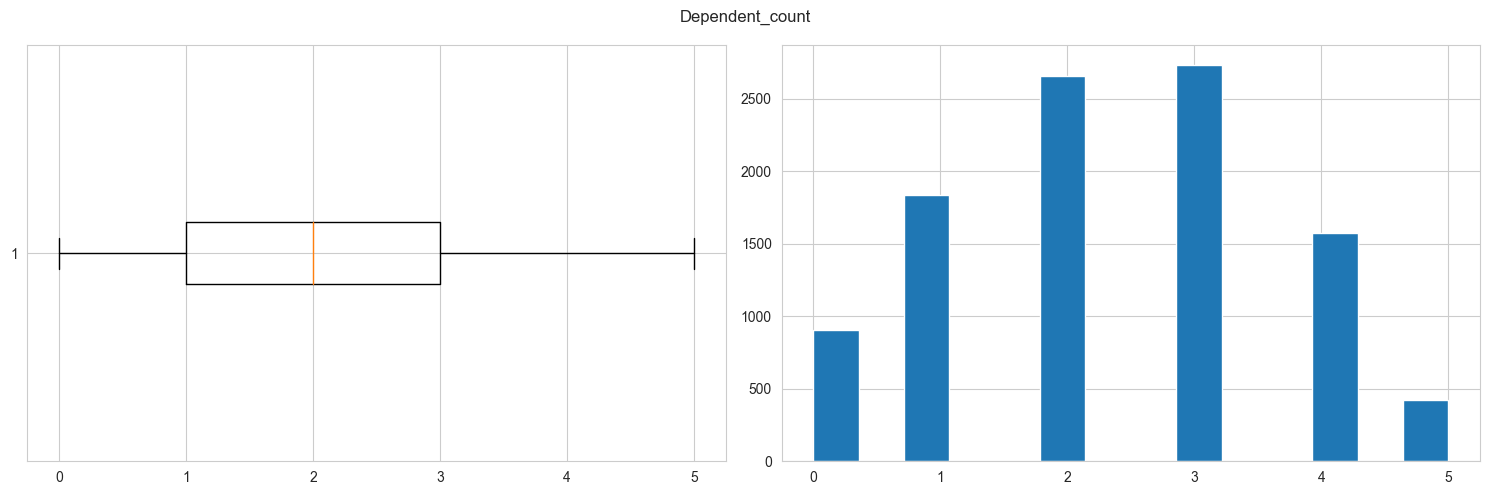

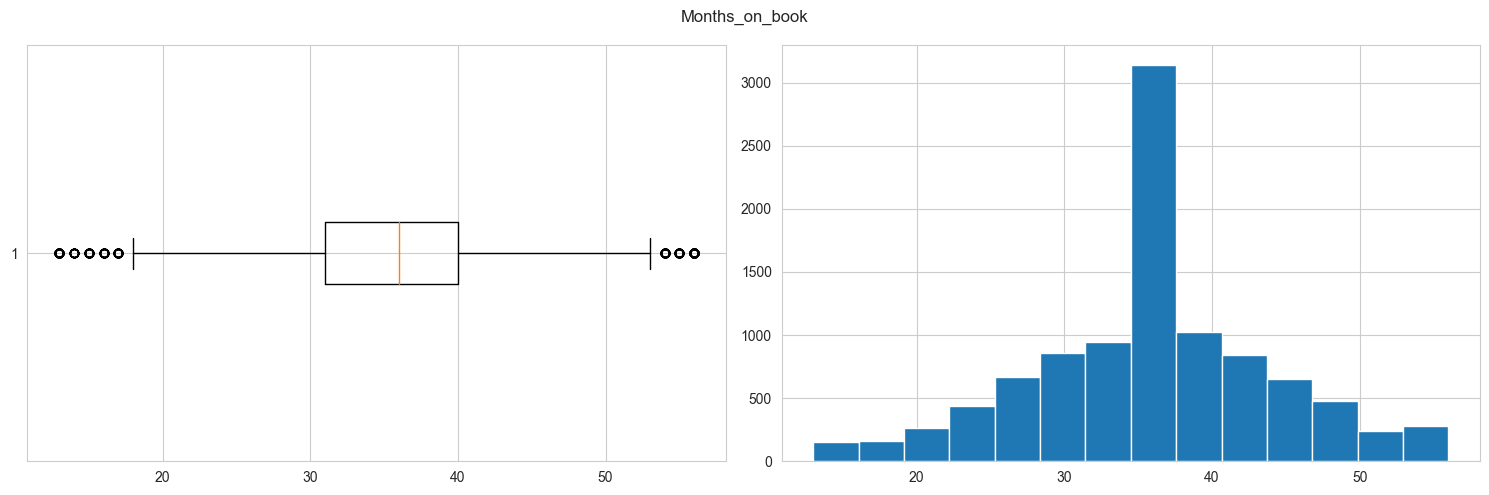

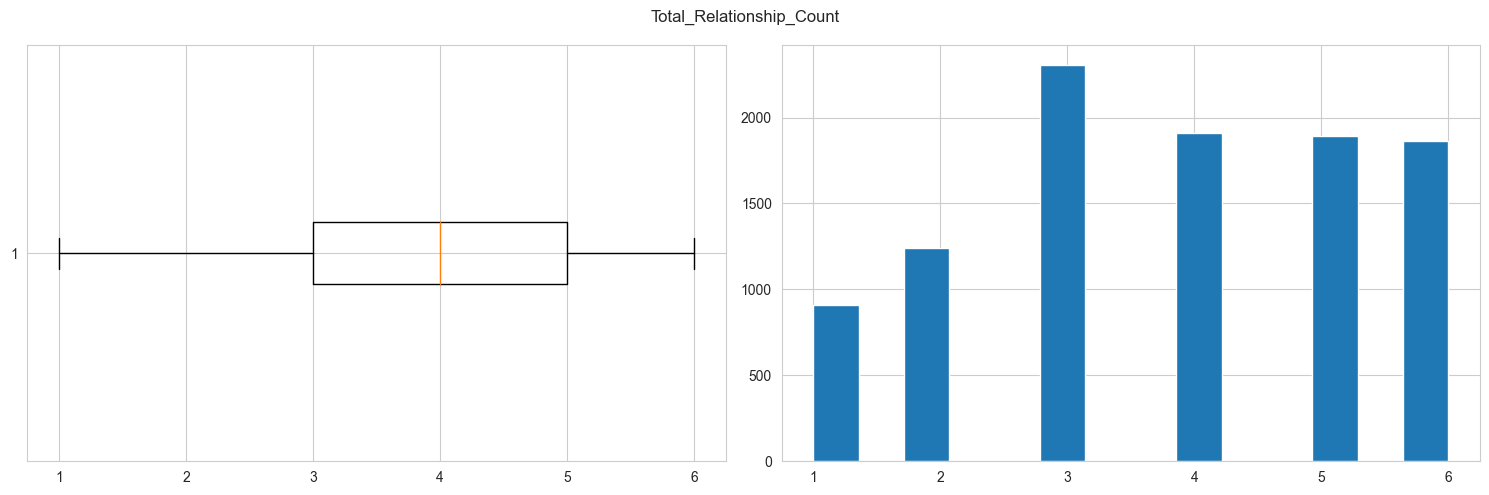

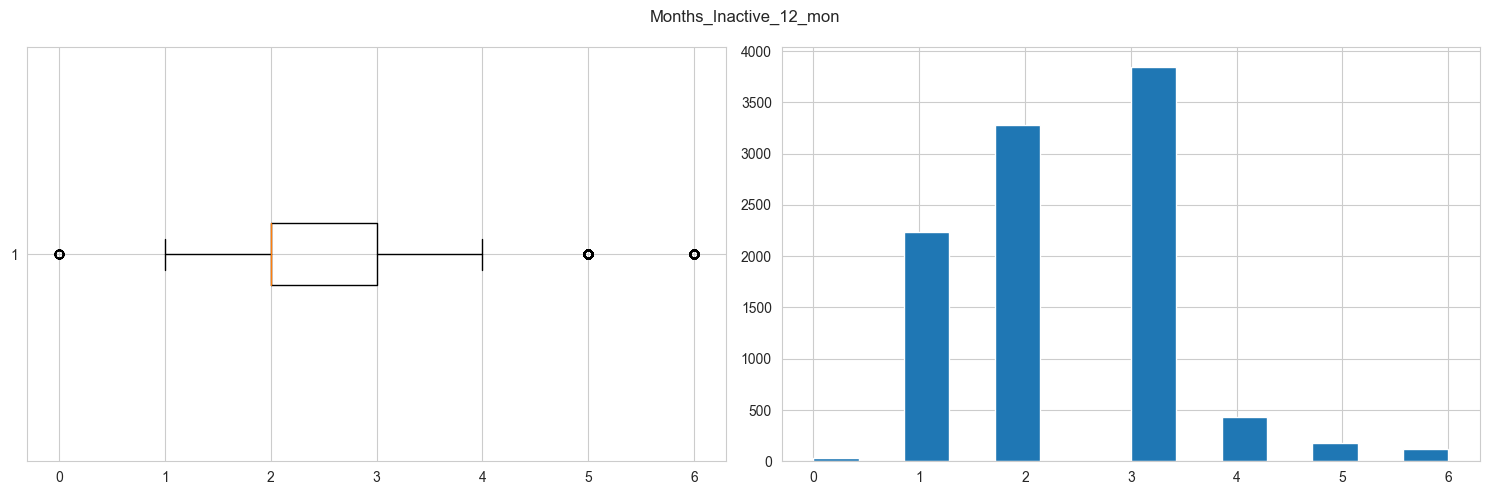

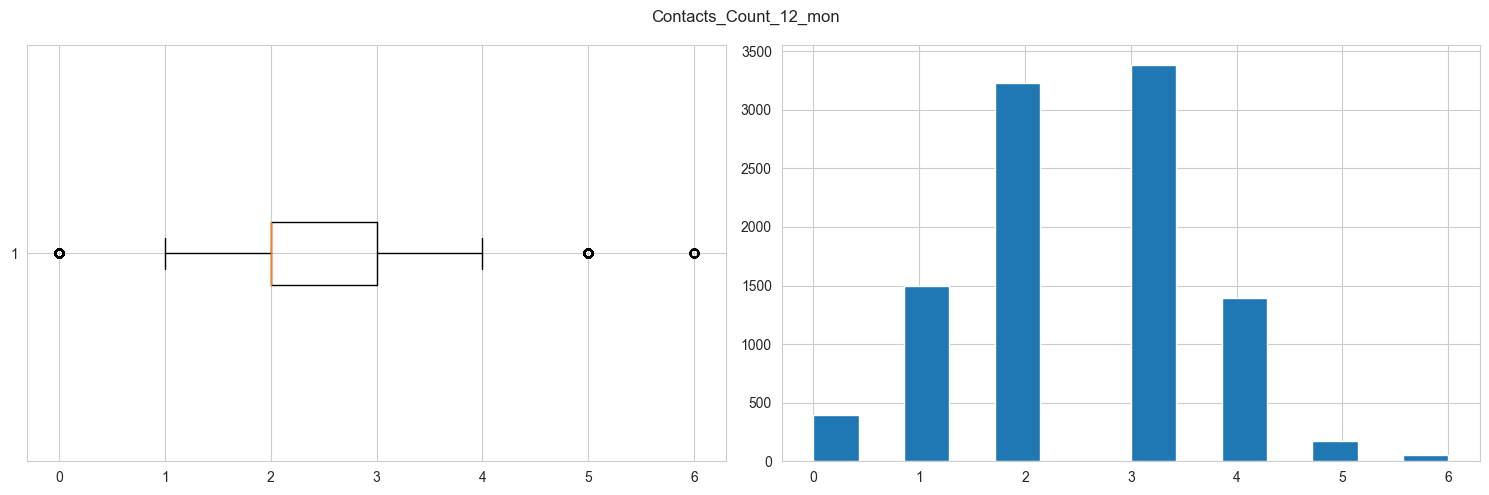

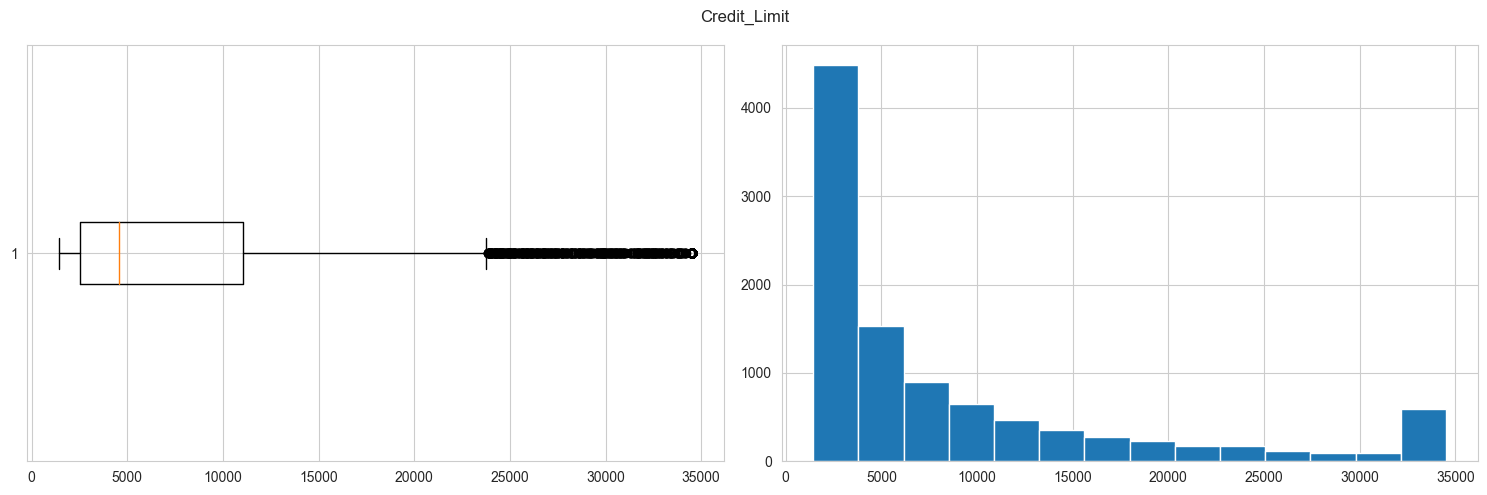

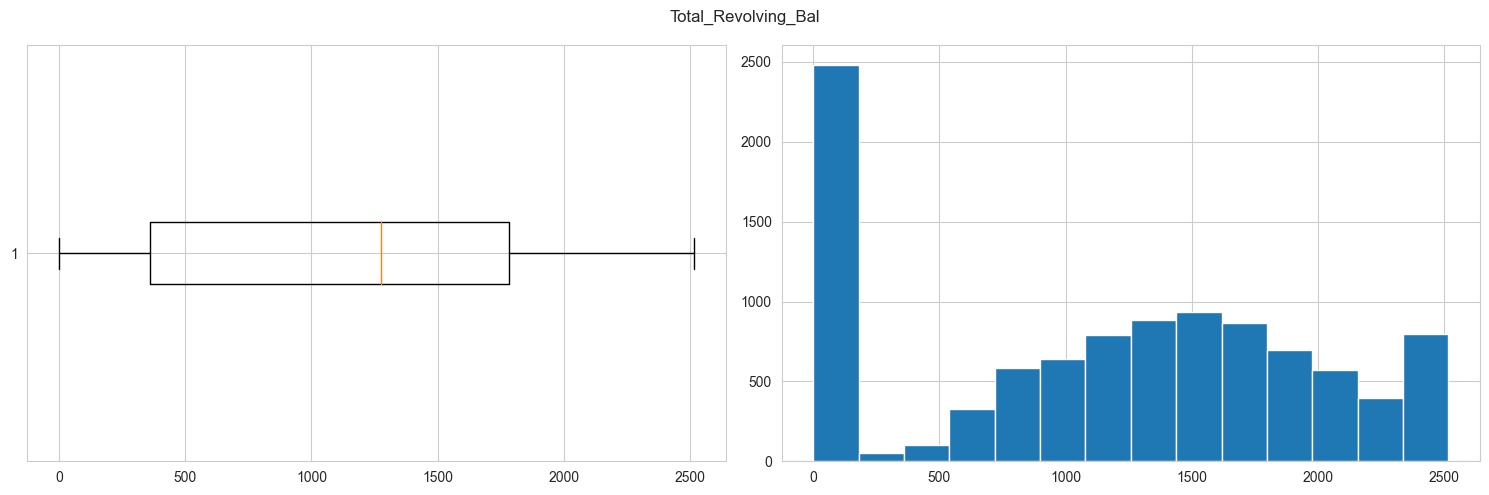

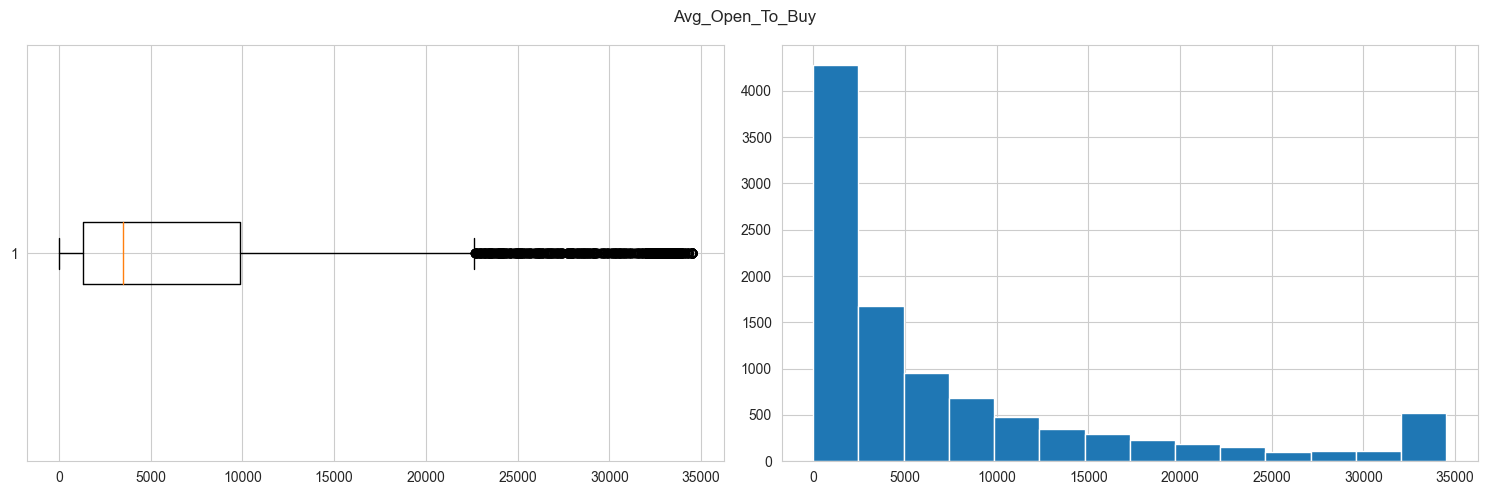

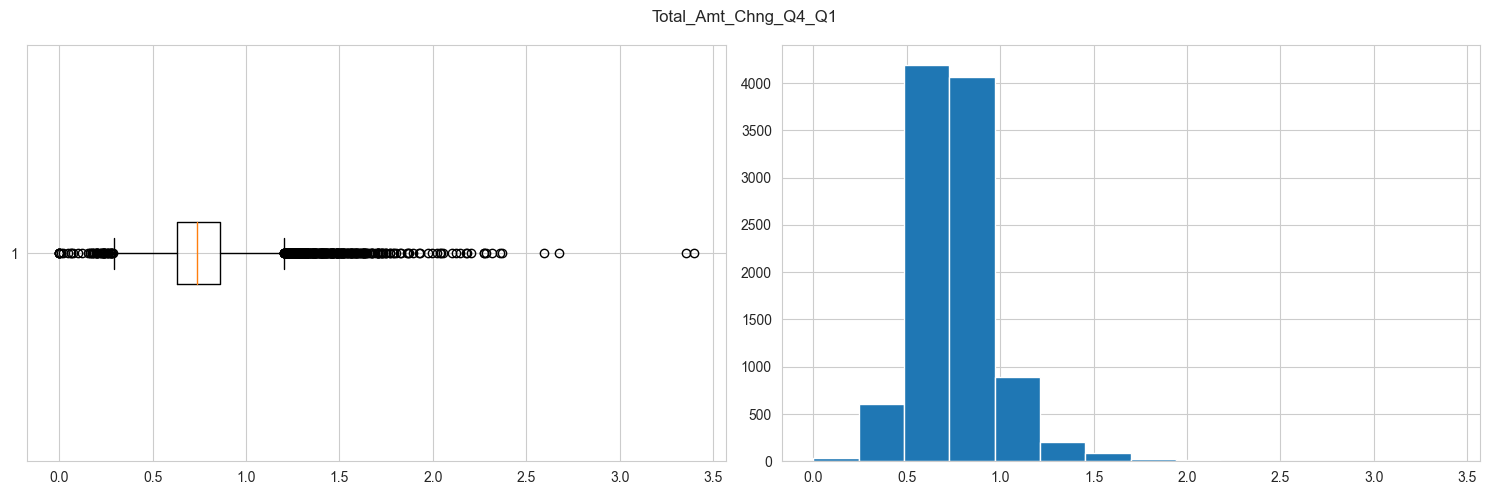

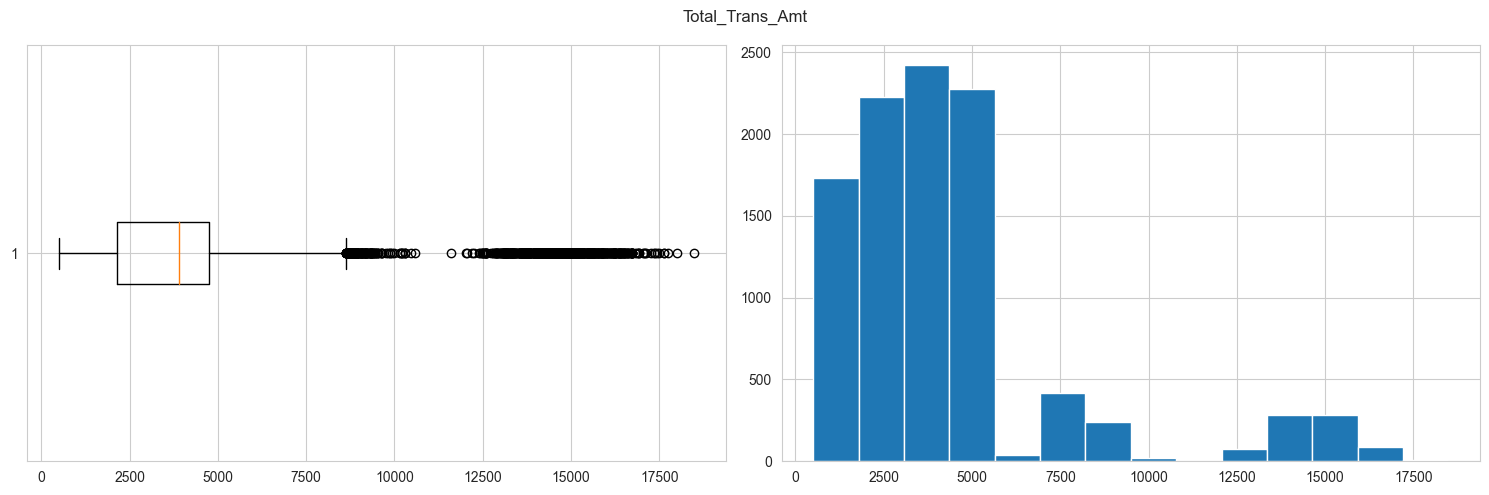

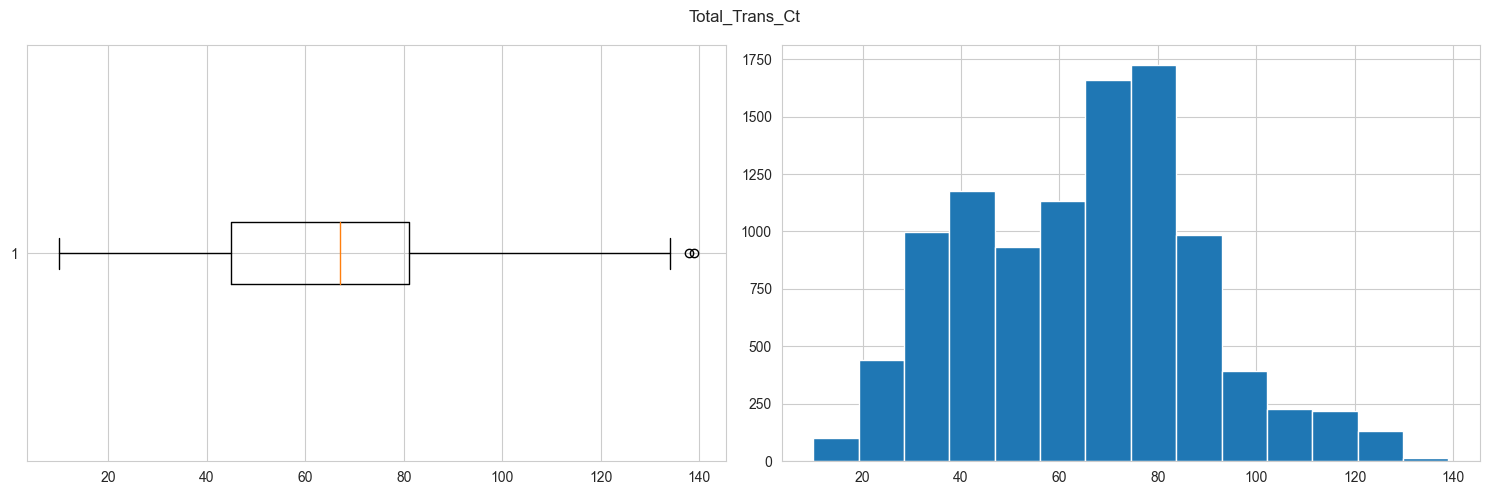

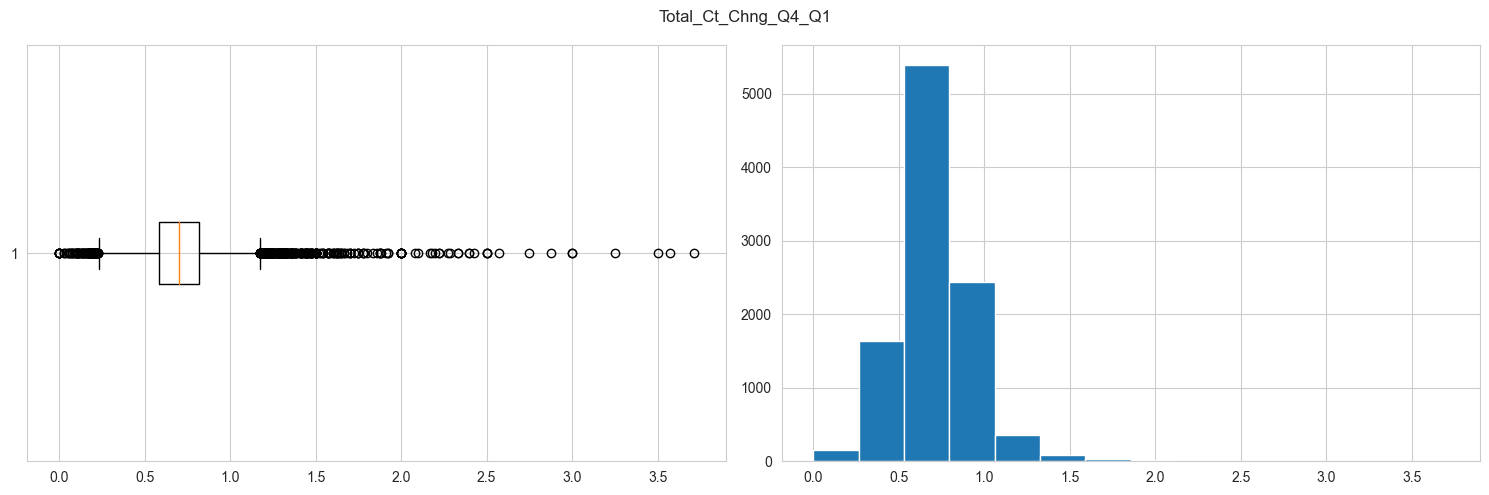

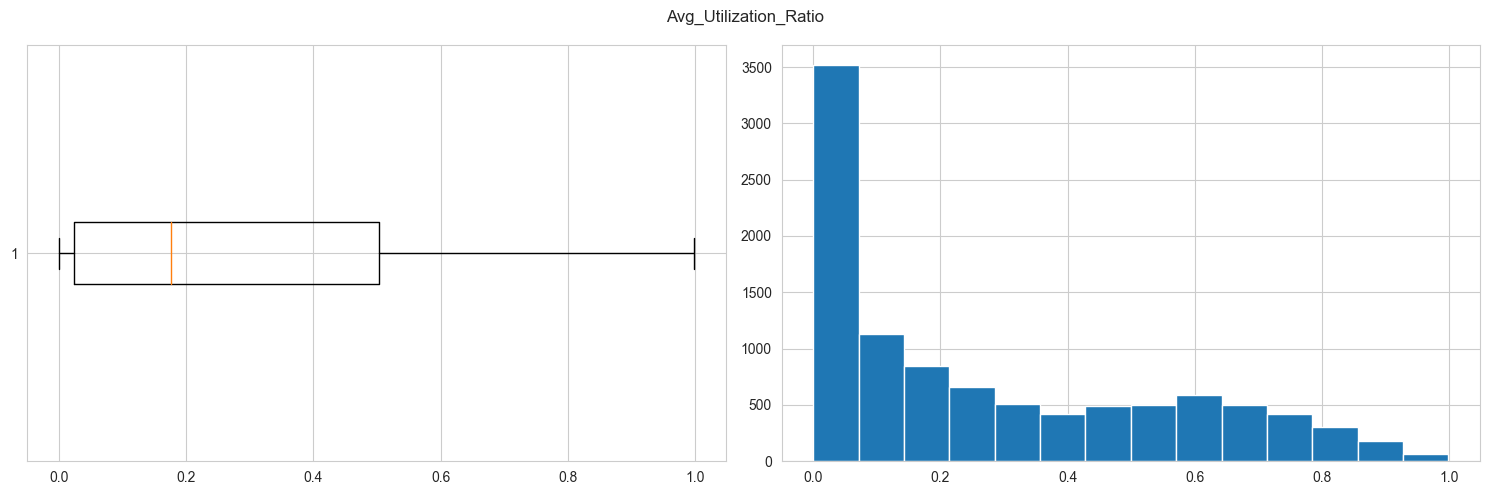

In [17]:
for column in numerical_columns:
    visualize_distribution(df, column)

### Missing Values

In [18]:
df.isnull().sum()

id                          0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

No NA or NaN, however from the value count plots we could see there are some 'Unknown' values in the categorical features

In [19]:
df = df.replace('Unknown', np.nan)

## Bivariate data exploration

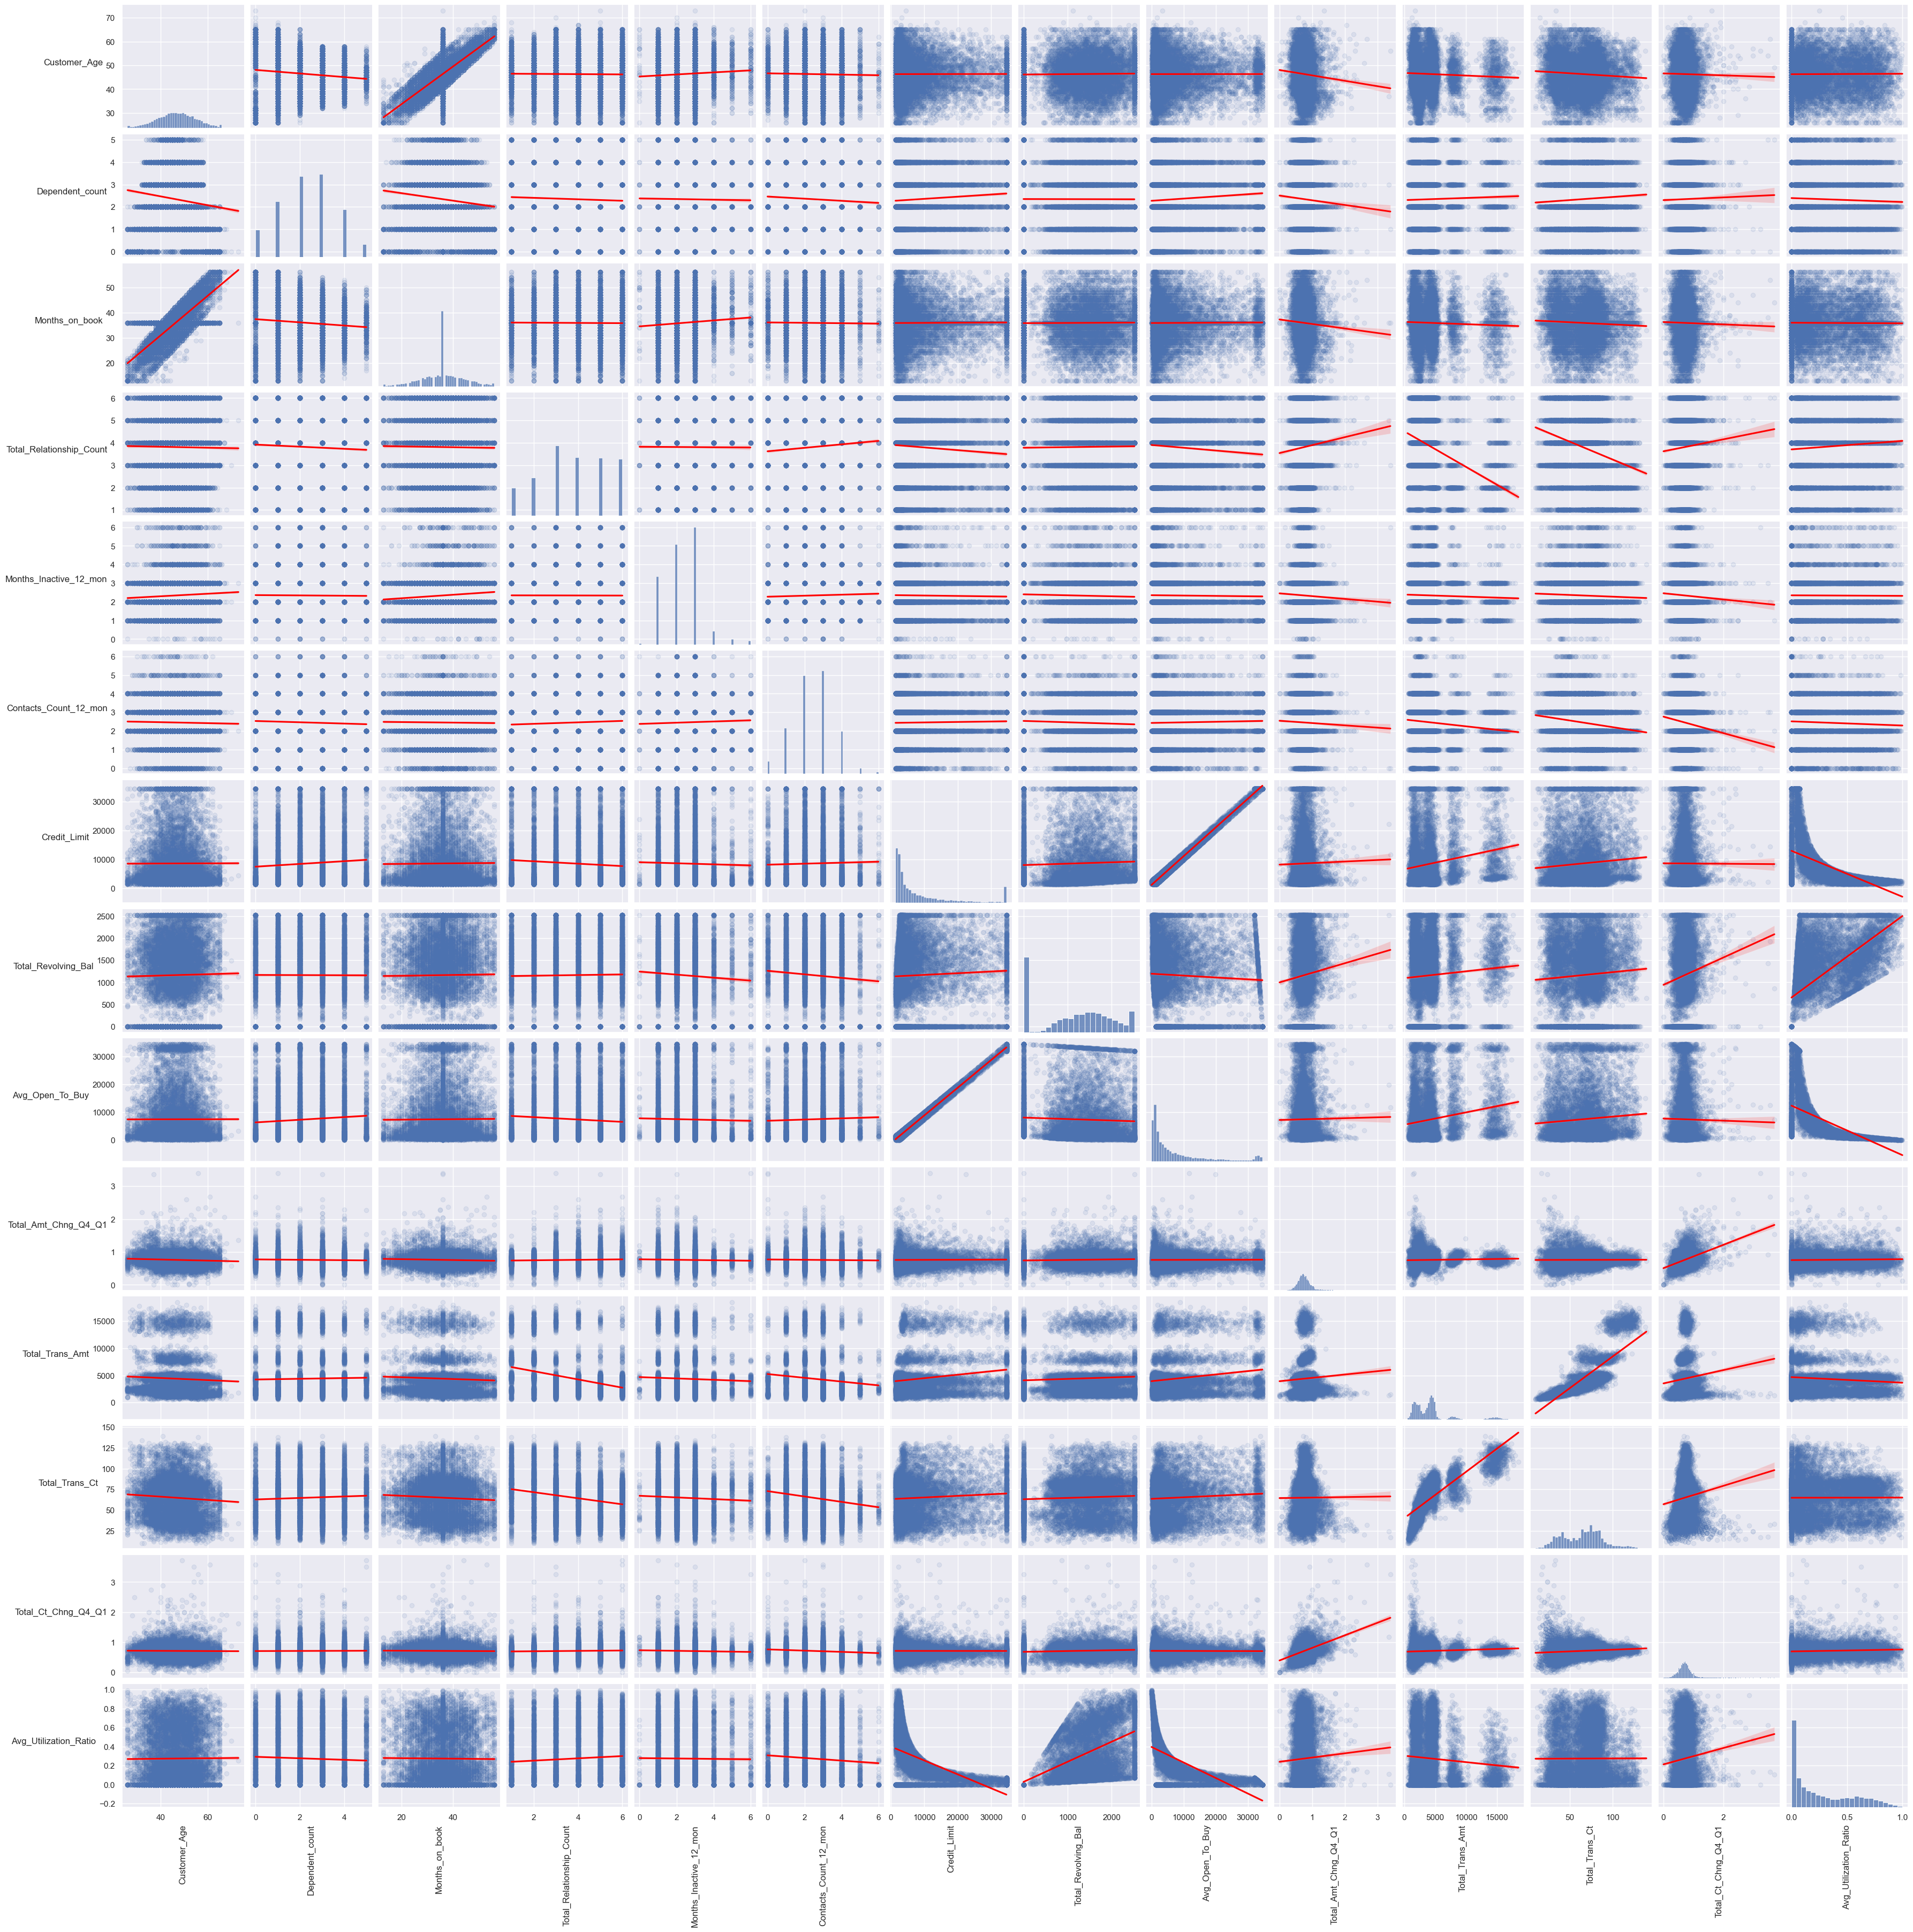

In [20]:
# may take a bit longer to execute ~2min
sns.set(font_scale = 1)
g=sns.pairplot(df[numerical_columns], kind="reg",plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}},diag_kind="hist")
for ax in g.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')

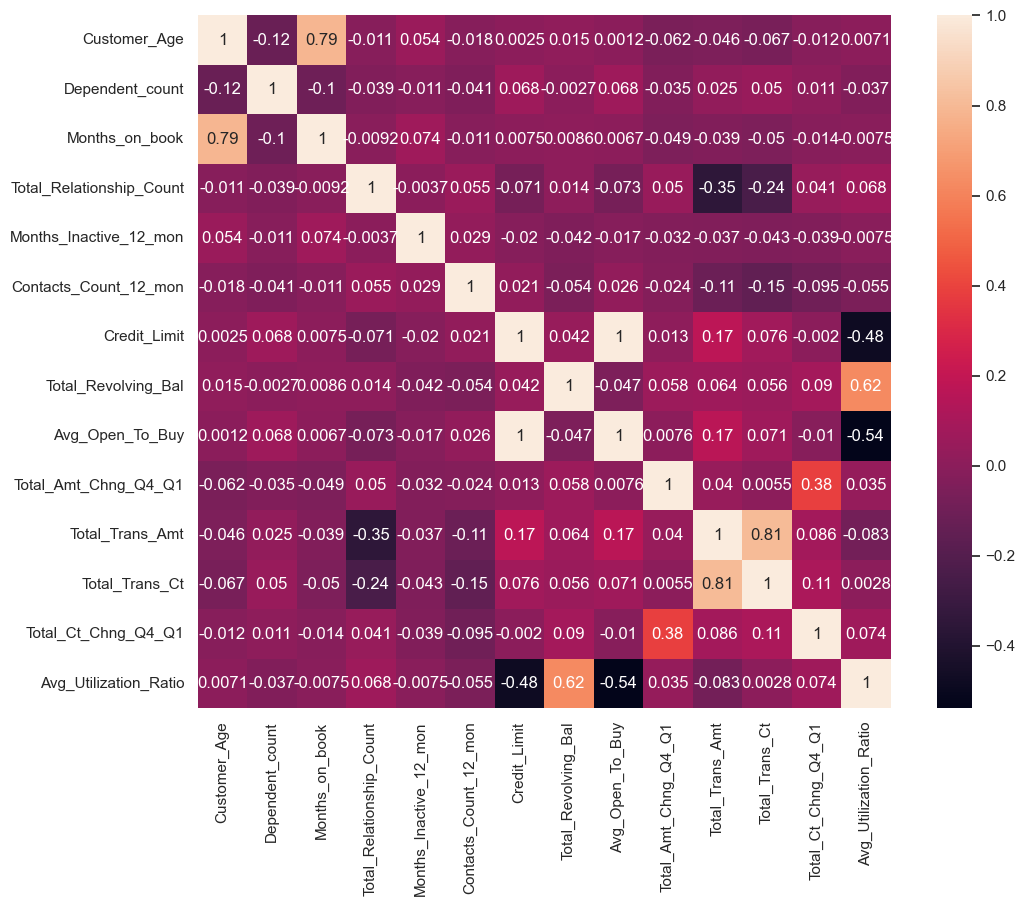

In [21]:
#correlation matrix
corrmat = df[numerical_columns].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True, annot=True);

In [22]:
corrmat

Customer_Age  Dependent_count  Months_on_book   
Customer_Age                  1.000000        -0.122254        0.788912  \
Dependent_count              -0.122254         1.000000       -0.103062   
Months_on_book                0.788912        -0.103062        1.000000   
Total_Relationship_Count     -0.010931        -0.039076       -0.009203   
Months_Inactive_12_mon        0.054361        -0.010768        0.074164   
Contacts_Count_12_mon        -0.018452        -0.040505       -0.010774   
Credit_Limit                  0.002476         0.068065        0.007507   
Total_Revolving_Bal           0.014780        -0.002688        0.008623   
Avg_Open_To_Buy               0.001151         0.068291        0.006732   
Total_Amt_Chng_Q4_Q1         -0.062042        -0.035439       -0.048959   
Total_Trans_Amt              -0.046446         0.025046       -0.038591   
Total_Trans_Ct               -0.067097         0.049912       -0.049819   
Total_Ct_Chng_Q4_Q1          -0.012143         0.011087       -0.014072   
Avg_Utilization_Ratio         0.007114        -0.037135       -0.007541   

                          Total_Relationship_Count  Months_Inactive_12_mon   
Customer_Age                             -0.010931                0.054361  \
Dependent_count                          -0.039076               -0.010768   
Months_on_book                           -0.009203                0.074164   
Total_Relationship_Count                  1.000000               -0.003675   
Months_Inactive_12_mon                   -0.003675                1.000000   
Contacts_Count_12_mon                     0.055203                0.029493   
Credit_Limit                             -0.071386               -0.020394   
Total_Revolving_Bal                       0.013726               -0.042210   
Avg_Open_To_Buy                          -0.072601               -0.016605   
Total_Amt_Chng_Q4_Q1                      0.050119               -0.032247   
Total_Trans_Amt                          -0.347229               -0.036982   
Total_Trans_Ct                           -0.241891               -0.042787   
Total_Ct_Chng_Q4_Q1                       0.040831               -0.038989   
Avg_Utilization_Ratio                     0.067663               -0.007503   

                          Contacts_Count_12_mon  Credit_Limit   
Customer_Age                          -0.018452      0.002476  \
Dependent_count                       -0.040505      0.068065   
Months_on_book                        -0.010774      0.007507   
Total_Relationship_Count               0.055203     -0.071386   
Months_Inactive_12_mon                 0.029493     -0.020394   
Contacts_Count_12_mon                  1.000000      0.020817   
Credit_Limit                           0.020817      1.000000   
Total_Revolving_Bal                   -0.053913      0.042493   
Avg_Open_To_Buy                        0.025646      0.995981   
Total_Amt_Chng_Q4_Q1                  -0.024445      0.012813   
Total_Trans_Amt                       -0.112774      0.171730   
Total_Trans_Ct                        -0.152213      0.075927   
Total_Ct_Chng_Q4_Q1                   -0.094997     -0.002020   
Avg_Utilization_Ratio                 -0.055471     -0.482965   

                          Total_Revolving_Bal  Avg_Open_To_Buy   
Customer_Age                         0.014780         0.001151  \
Dependent_count                     -0.002688         0.068291   
Months_on_book                       0.008623         0.006732   
Total_Relationship_Count             0.013726        -0.072601   
Months_Inactive_12_mon              -0.042210        -0.016605   
Contacts_Count_12_mon               -0.053913         0.025646   
Credit_Limit                         0.042493         0.995981   
Total_Revolving_Bal                  1.000000        -0.047167   
Avg_Open_To_Buy                     -0.047167         1.000000   
Total_Amt_Chng_Q4_Q1                 0.058174         0.007595   
Total_Trans_Amt            

Visualize distributions with respect to the target class

In [23]:
def visualize_distribution_tc(df, numerical_columns):
    fig, ax = plt.subplots(7, 2, tight_layout=True, figsize=(20, 60))
    for i, column in enumerate(numerical_columns):
        fig.suptitle(column)
        sns.boxplot(y=column, x='Attrition_Flag', hue='Attrition_Flag', data=df, ax=ax[math.floor(i/2)][i%2])
    fig.tight_layout()

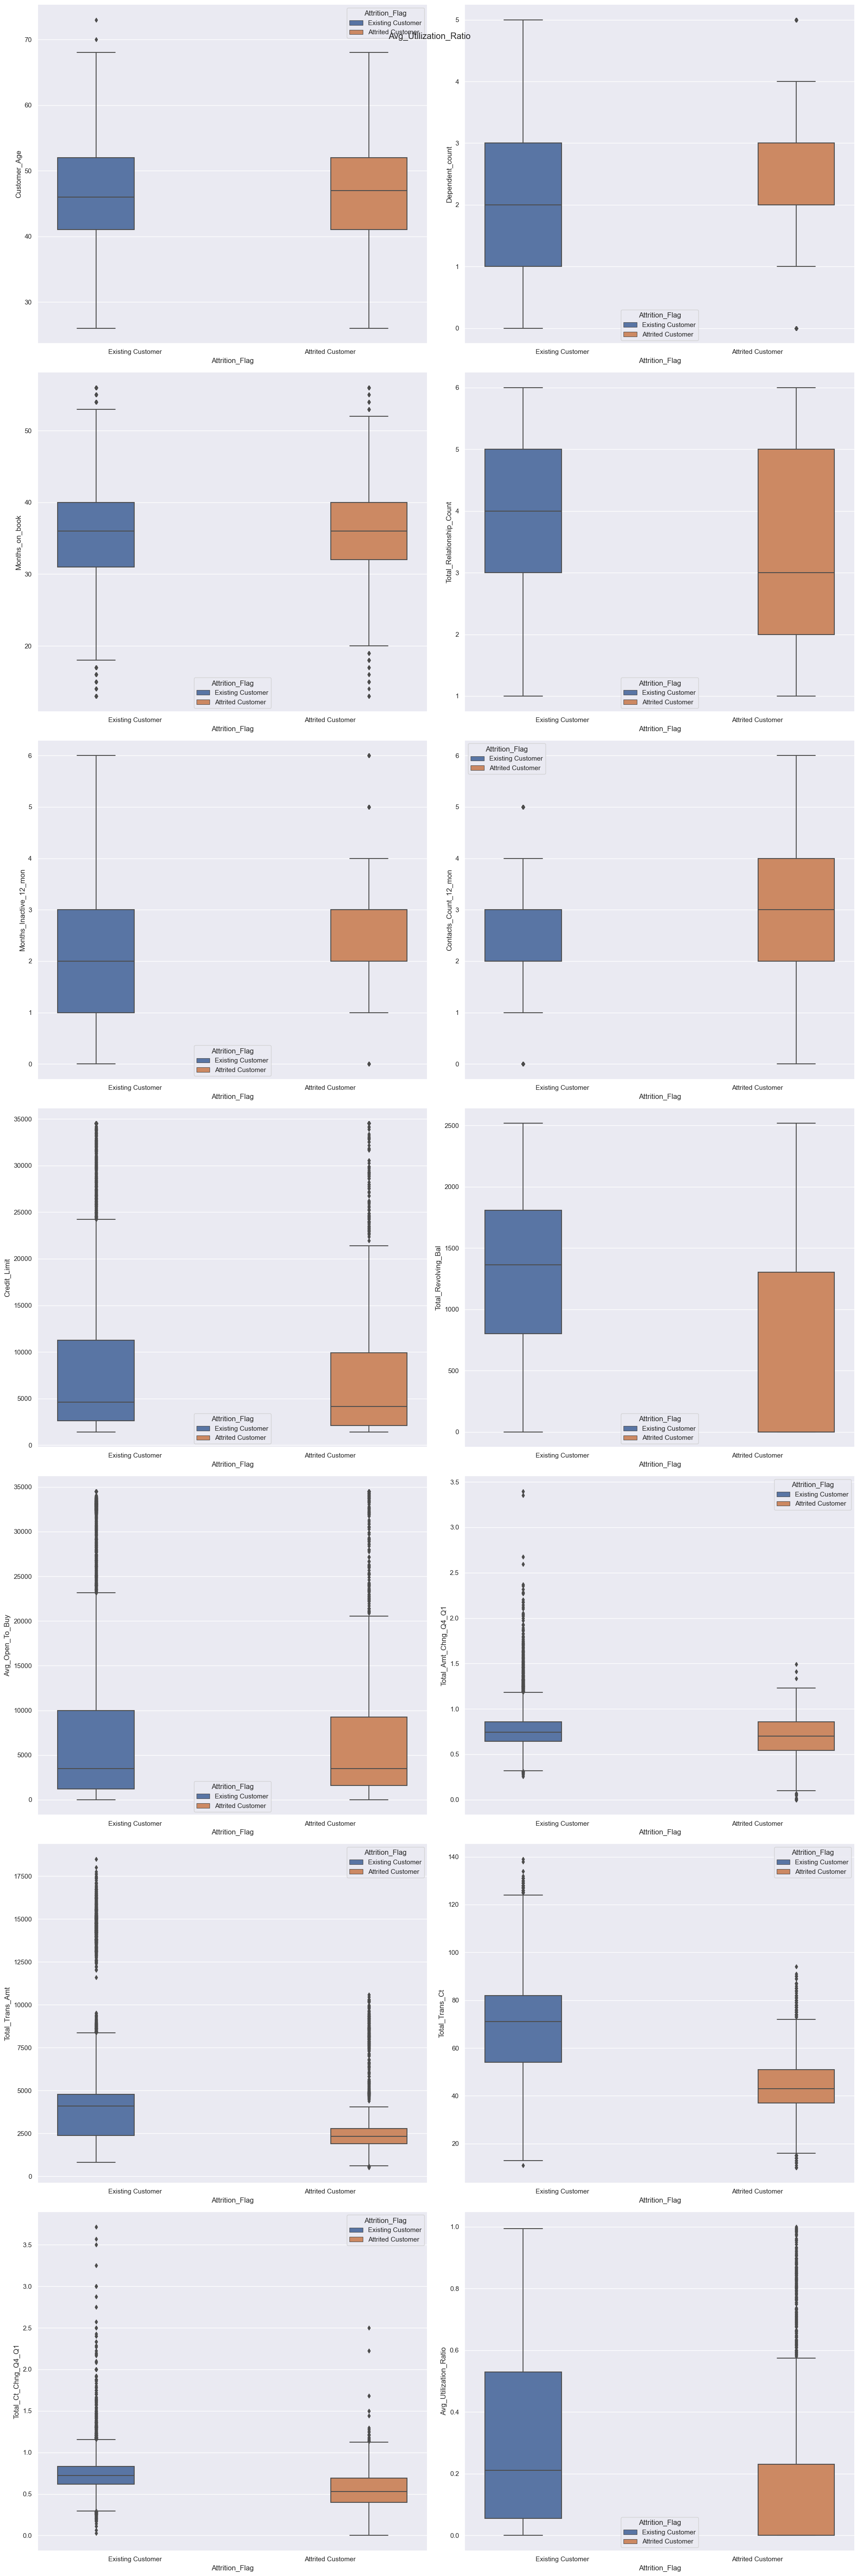

In [24]:
visualize_distribution_tc(df, numerical_columns)

In [25]:
def visualize_distribution_cat_tc(df, categorical_columns):
    fig, ax = plt.subplots(3, 2, tight_layout=True, figsize=(20, 30))
    for i, column in enumerate(categorical_columns, start=-1):
        if column == 'Attrition_Flag':
            continue
        fig.suptitle(column)
        sns.countplot(x=column, hue='Attrition_Flag', data=df, ax=ax[math.floor(i/2)][i%2])
    fig.tight_layout()

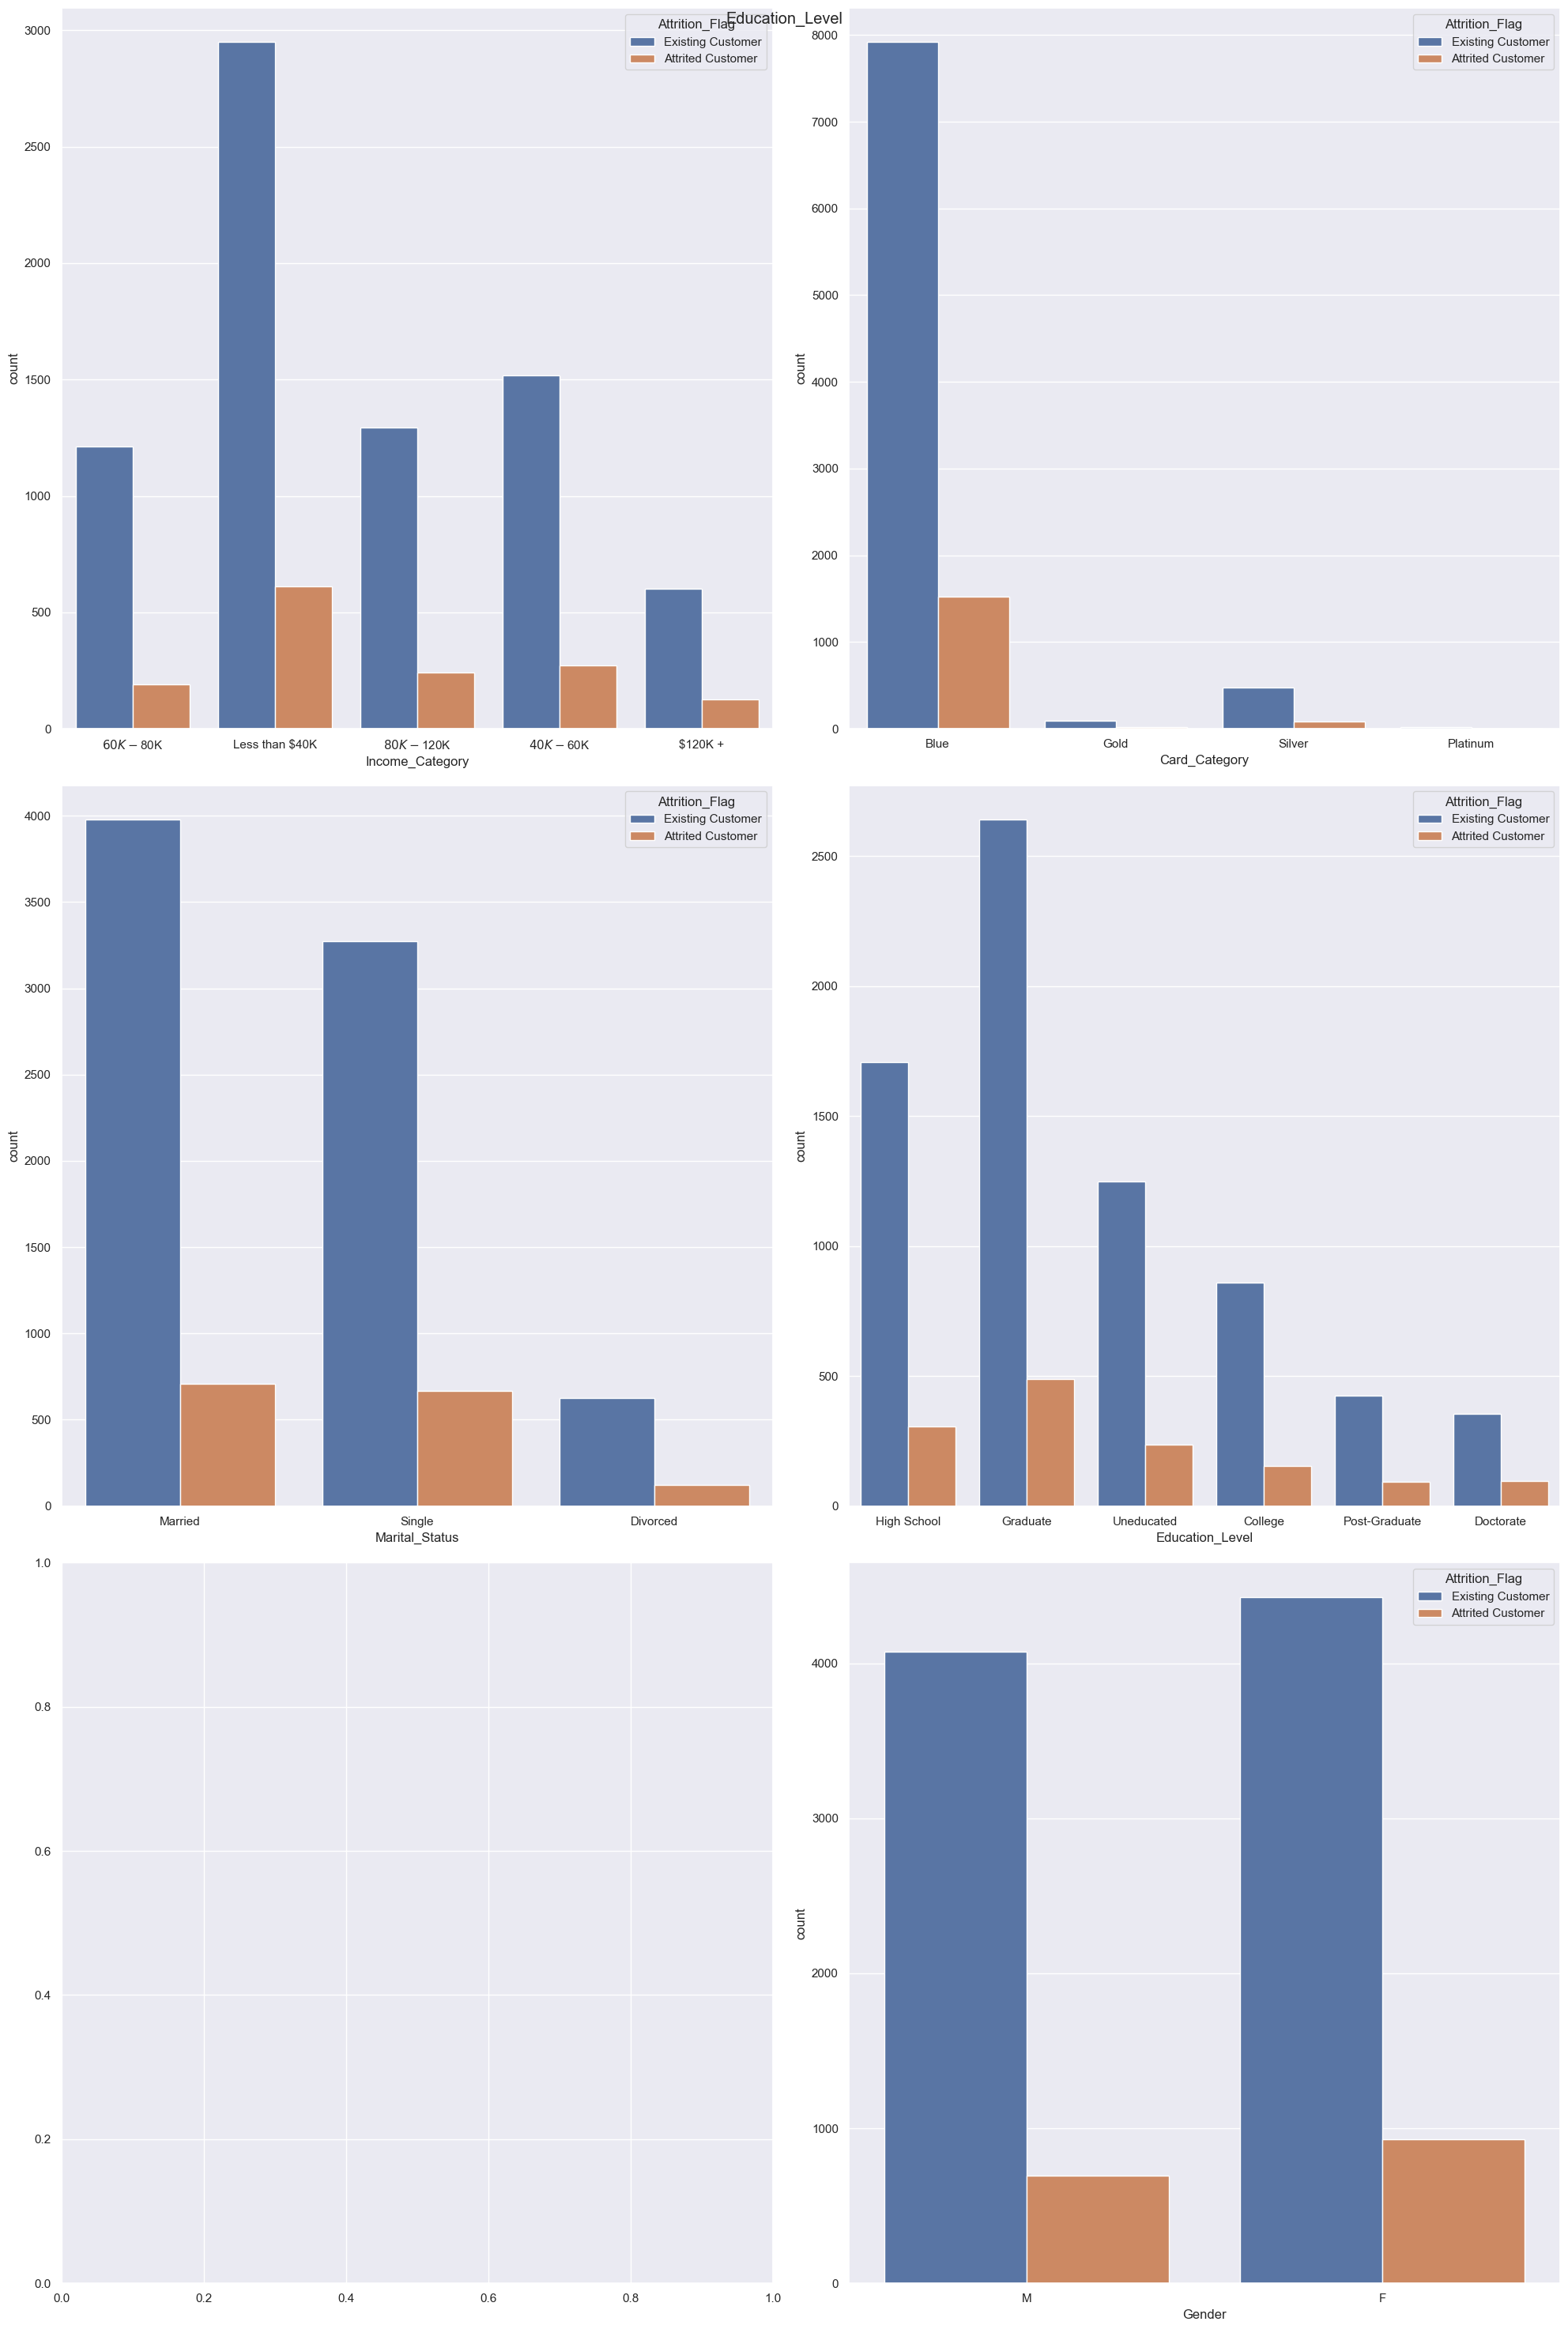

In [26]:
visualize_distribution_cat_tc(df, categorical_columns)

In [27]:
def cat_tc_percentage(df, categorical_columns):
    fig, ax = plt.subplots(3, 2, tight_layout=True, figsize=(20, 30))
    for index, column in enumerate(categorical_columns, start=-1):
        if column == 'Attrition_Flag':
            continue
        attrited = df[df["Attrition_Flag"] == 'Attrited Customer'][[column]].value_counts()
        original = df[column].value_counts()
        percentage = original.copy() # construct series object with the same index
        for i in range(0, len(attrited)):  #  get percentage of attrited
            percentage[i] = attrited[i]/original[i] * 100
        plot = percentage.plot.bar(ax=ax[math.floor(index/2)][index % 2])
        ax[math.floor(index/2)][index % 2].set_ylabel("Attrition_Flag")
        i = 0
        for x,y in percentage.items():
            original_norm = df[column].value_counts(normalize=True)
            ax[math.floor(index/2)][index % 2].annotate(str(round(original_norm[i] * 100, 2)) + '%', (i, y - 2), va='center', ha='center', fontsize=18, color='black', fontweight=500)
            i += 1

        # plot line representing percentage of attrited customers
        plot.axhline(y= df["Attrition_Flag"].value_counts(normalize=True)['Attrited Customer'] * 100, color = 'red')


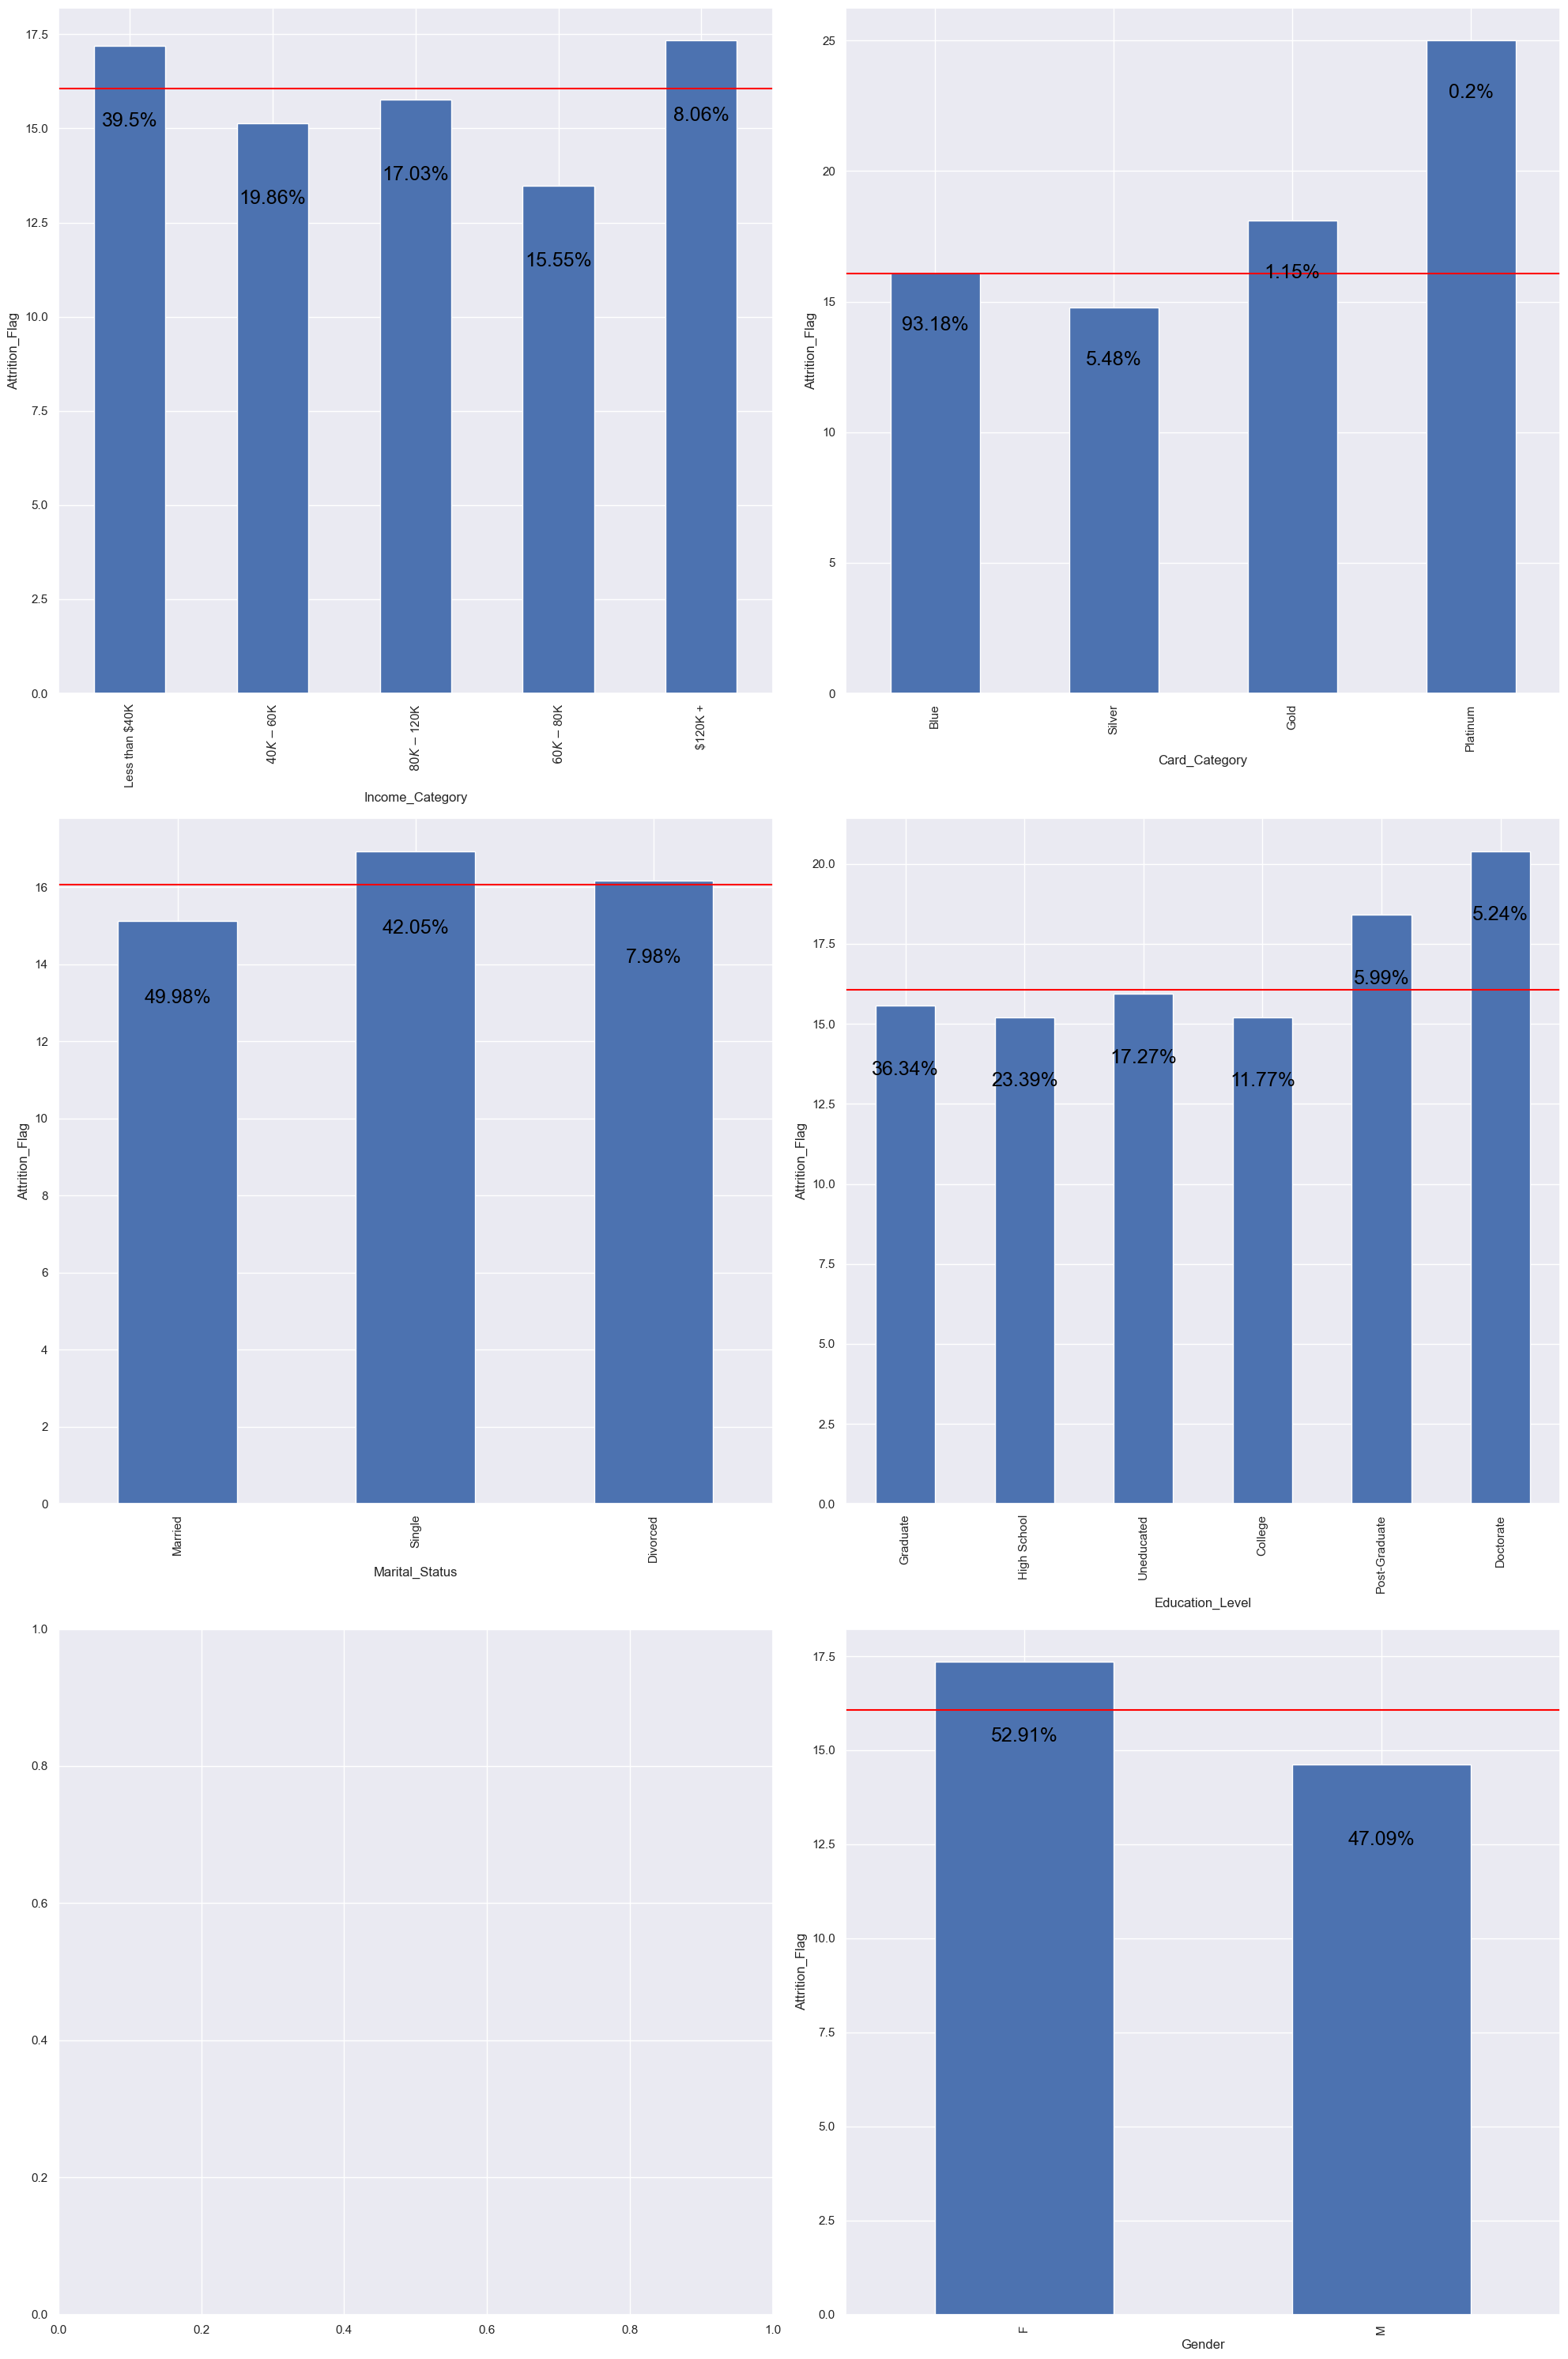

In [28]:
cat_tc_percentage(df, categorical_columns)

Some adjustments have been made to the data (irrelevant cols removed, unknowns replaced with na). We will save the modified data.

In [29]:
df.to_csv('data/processed/BankChurners_after-inspection.csv', index=False)


## CHECKPOINT 1

## Missing values imputation

As we saw in before, there were some 'unknown' values in categorical columns of the dataset.
We first changed the values to np.na and now we can use some missing values imputation methods to get rid of these unknown values. We will use decision tree and knn to impute the missing values. We will measure the performance of the two methods and choose the better one.

In [30]:
df = pd.read_csv('data/processed/BankChurners_after-inspection.csv')
df.head()
numerical_columns = df._get_numeric_data().columns.to_list()
categorical_columns = list(set(df.columns) - set(numerical_columns))
numerical_columns.remove('id')
categorical_columns_indices = [df.columns.get_loc(c) for c in categorical_columns if c in df]
numerical_columns_indices = [df.columns.get_loc(c) for c in numerical_columns if c in df]



In [31]:
df

id     Attrition_Flag  Customer_Age Gender  Dependent_count   
0          0  Existing Customer            45      M                3  \
1          1  Existing Customer            49      F                5   
2          2  Existing Customer            51      M                3   
3          3  Existing Customer            40      F                4   
4          4  Existing Customer            40      M                3   
...      ...                ...           ...    ...              ...   
10122  10122  Existing Customer            50      M                2   
10123  10123  Attrited Customer            41      M                2   
10124  10124  Attrited Customer            44      F                1   
10125  10125  Attrited Customer            30      M                2   
10126  10126  Attrited Customer            43      F                2   

      Education_Level Marital_Status Income_Category Card_Category   
0         High School        Married     $60K - $80K          Blue  \
1            Graduate         Single  Less than $40K          Blue   
2            Graduate        Married    $80K - $120K          Blue   
3         High School            NaN  Less than $40K          Blue   
4          Uneducated        Married     $60K - $80K          Blue   
...               ...            ...             ...           ...   
10122        Graduate         Single     $40K - $60K          Blue   
10123             NaN       Divorced     $40K - $60K          Blue   
10124     High School        Married  Less than $40K          Blue   
10125        Graduate            NaN     $40K - $60K          Blue   
10126        Graduate        Married  Less than $40K        Silver   

       Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon   
0                  39  ...                       1                      3  \
1                  44  ...                       1                      2   
2                  36  ...                       1                      0   
3                  34  ...                       4                      1   
4                  21  ...                       1                      0   
...               ...  ...                     ...                    ...   
10122              40  ...                       2                      3   
10123              25  ...                       2                      3   
10124              36  ...                       3                      4   
10125              36  ...                       3                      3   
10126              25  ...                       2                      4   

       Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy   
0           12691.0                  777          11914.0  \
1            8256.0                  864           7392.0   
2            3418.0                    0           3418.0   
3            3313.0                 2517            796.0   
4            4716.0                    0           4716.0   
...             ...                  ...              ...   
10122        4003.0                 1851           2152.0   
10123        4277.0                 2186           2091.0   
10124        5409.0                    0           5409.0   
10125        5281.0                    0           5281.0   
10126       10388.0                 1961           8427.0   

       Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct   
0                     1.335             1144              42  \
1                     1.541             1291              33   
2                     2.594             1887              20   
3                     1.405             1171              20   
4                     2.175              816              28   
...                     ...              ...             ...   
10122                 0.703            15476             117   
10123                 0.804             8764              69   
10124                 0.819            10291              

The functions below aren't directly related to dealing with missing values, however the methods we use for imputation need some preprocessing since we train ML models to impute the data. Therefore, we declare these functions here and they will also be used later (when dealing with categorical data or normalizing numerical).

In [32]:
import json
from sklearn.preprocessing import OrdinalEncoder

def ordinal_encode(_df, ommit_col=None):
    """
     returns encoded df and indices of columns that were encoded
    """
    encoded_df = _df.copy()
    encoded_df = encoded_df[encoded_df.notna()]
    f = open('data/utility/BankChurners_cat_cols_order.json')
    ordinal_mapping = json.load(f)
    sorted_features_list = []
    for col in ordinal_mapping:
        if col == ommit_col:
            continue
        sorted_features_list.append(ordinal_mapping[col])
    cols = list(ordinal_mapping.keys())
    if ommit_col in cols:
        cols.remove(ommit_col)
    encoder = OrdinalEncoder(categories=sorted_features_list)
    encoded_df[cols] = encoder.fit_transform(
        encoded_df[cols])
    return encoded_df

In [33]:
from sklearn.preprocessing import MinMaxScaler


def minmax_num_atts(_df, numeric):
    """
    applies minmaxscaler to numeric columns of data frame
    """
    df_norm = _df.copy()
    scaler = MinMaxScaler()
    df_norm.iloc[:, numeric] = scaler.fit_transform((df_norm.iloc[:, numeric]))
    return df_norm

In [34]:
df.isna().sum()

id                             0
Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category             1112
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

In [35]:
dtree_imputation_results = {}
knn_imputation_results = {}

In [36]:
from sklearn.tree import DecisionTreeClassifier

def impute_missing_dtree(_df, col_names_to_impute):
    df = _df.copy()
    other_col_names = col_names_to_impute.copy()

    for currently_imputed_col_name in col_names_to_impute:
        impute_df = df.copy()
        other_col_names.remove(currently_imputed_col_name)
        # other columns with missing values will be temporary imputed with modes (categorical suited)
        for other_col_name in other_col_names:
            impute_df[other_col_name] = impute_df[other_col_name].fillna(impute_df[other_col_name].mode()[0])

        print(impute_df[currently_imputed_col_name].isna().sum())
        # preprocessing
        id_col = impute_df['id']
        currently_imputed_col_vals = impute_df[currently_imputed_col_name]
        # encode categorical
        impute_df = ordinal_encode(drop_col(impute_df, currently_imputed_col_name), currently_imputed_col_name)
        numerical_columns = impute_df._get_numeric_data().columns.to_list()
        num_indices = [impute_df.columns.get_loc(c) for c in numerical_columns if c in impute_df]
        impute_df = minmax_num_atts(impute_df, num_indices)
        impute_df = pd.get_dummies(drop_col(impute_df, currently_imputed_col_name))

        impute_df[currently_imputed_col_name] = currently_imputed_col_vals
        impute_df['id'] = id_col

        # select rows that dont contain na in the col that is being imputed to train dtree
        df_train = impute_df[impute_df[currently_imputed_col_name].notna()]
        target = df_train[currently_imputed_col_name]
        print(currently_imputed_col_name)

        df_train = drop_col(df_train, currently_imputed_col_name)
        df_train = drop_col(df_train, 'id')
        X_train, X_test, y_train, y_test = train_test_split(df_train, target, test_size=0.2, random_state=5)

        # train tree TODO: some hyperparameter tuning (done manually)
        tree = DecisionTreeClassifier(min_samples_leaf=10, ccp_alpha=0.0007)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_train)
        print("Accuracy train:",metrics.accuracy_score(y_train, y_pred))
        y_pred = tree.predict(X_test)
        print("Accuracy test:",metrics.accuracy_score(y_test, y_pred))
        dtree_imputation_results[currently_imputed_col_name] = metrics.accuracy_score(y_test, y_pred)

        # tree will predict value on rows with missing values
        x_test = impute_df[impute_df[currently_imputed_col_name].isna()]
        x_test = drop_col(x_test, 'id')
        x_test = drop_col(x_test, currently_imputed_col_name)

        predicted = tree.predict(x_test)
        unique, counts = np.unique(predicted, return_counts=True)
        print(np.asarray((unique, counts)).T)
        x_test[currently_imputed_col_name] = predicted
        # update based on index
        df.update(x_test[currently_imputed_col_name])

    return df

In [37]:
df_imputed_dt = impute_missing_dtree(df, ['Education_Level', 'Marital_Status','Income_Category'])

1519
Education_Level
Accuracy train: 0.36407203020621554
Accuracy test: 0.3606271777003484
[['Graduate' 1519]]
749
Marital_Status
Accuracy train: 0.5967741935483871
Accuracy test: 0.5538379530916845
[['Married' 540]
 ['Single' 209]]
1112
Income_Category
Accuracy train: 0.6100942872989462
Accuracy test: 0.6001109262340544
[['$40K - $60K' 352]
 ['$60K - $80K' 16]
 ['$80K - $120K' 17]
 ['Less than $40K' 727]]


In [38]:

from sklearn.neighbors import KNeighborsClassifier

def impute_missing_knn(_df, col_names_to_impute):
    df = _df.copy()
    other_col_names = col_names_to_impute.copy()

    for currently_imputed_col_name in col_names_to_impute:
        impute_df = df.copy()
        other_col_names.remove(currently_imputed_col_name)
        # other columns with missing values will be temporary imputed with modes (categorical suited)
        for other_col_name in other_col_names:
            impute_df[other_col_name] = impute_df[other_col_name].fillna(impute_df[other_col_name].mode()[0])

        print(impute_df[currently_imputed_col_name].isna().sum())
        # preprocessing
        id_col = impute_df['id']
        currently_imputed_col_vals = impute_df[currently_imputed_col_name]
        # encode categorical
        impute_df = ordinal_encode(drop_col(impute_df, currently_imputed_col_name), currently_imputed_col_name)
        numerical_columns = impute_df._get_numeric_data().columns.to_list()
        num_indices = [impute_df.columns.get_loc(c) for c in numerical_columns if c in impute_df]
        impute_df = minmax_num_atts(impute_df, num_indices)
        impute_df = pd.get_dummies(drop_col(impute_df, currently_imputed_col_name))

        impute_df[currently_imputed_col_name] = currently_imputed_col_vals
        impute_df['id'] = id_col

        # select rows that dont contain na in the col that is being imputed to train dtree
        df_train = impute_df[impute_df[currently_imputed_col_name].notna()]
        target = df_train[currently_imputed_col_name]
        print(currently_imputed_col_name)
        df_train = drop_col(df_train, currently_imputed_col_name)
        df_train = drop_col(df_train, 'id')
        X_train, X_test, y_train, y_test = train_test_split(df_train, target, test_size=0.2, random_state=5)

        knn = KNeighborsClassifier(n_neighbors=15)
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_train)
        print("Accuracy train:",metrics.accuracy_score(y_train, y_pred))
        y_pred = knn.predict(X_test)
        print("Accuracy test:",metrics.accuracy_score(y_test, y_pred))
        knn_imputation_results[currently_imputed_col_name] = metrics.accuracy_score(y_test, y_pred)
        # tree will predict value on rows with missing values
        x_test = impute_df[impute_df[currently_imputed_col_name].isna()]
        x_test = drop_col(x_test, 'id')
        x_test = drop_col(x_test, currently_imputed_col_name)

        predicted = knn.predict(x_test)
        unique, counts = np.unique(predicted, return_counts=True)
        print(np.asarray((unique, counts)).T)
        x_test[currently_imputed_col_name] = predicted
        # update based on index
        df.update(x_test[currently_imputed_col_name])

    return df

In [39]:
df_imputed_knn = impute_missing_knn(df, ['Education_Level', 'Marital_Status','Income_Category'])

1519
Education_Level
Accuracy train: 0.4080743537612547
Accuracy test: 0.30255516840882696
[['College' 63]
 ['Doctorate' 5]
 ['Graduate' 1082]
 ['High School' 264]
 ['Post-Graduate' 1]
 ['Uneducated' 104]]
749
Marital_Status
Accuracy train: 0.6131698213809651
Accuracy test: 0.5133262260127932
[['Divorced' 2]
 ['Married' 495]
 ['Single' 252]]
1112
Income_Category
Accuracy train: 0.610648918469218
Accuracy test: 0.5574043261231281
[['$120K +' 5]
 ['$40K - $60K' 102]
 ['$60K - $80K' 19]
 ['$80K - $120K' 18]
 ['Less than $40K' 968]]


In [40]:
imputation_results_df = pd.DataFrame()
imputation_results_df = imputation_results_df._append(dtree_imputation_results, ignore_index=True)
imputation_results_df = imputation_results_df._append(knn_imputation_results, ignore_index=True)
imputation_results_df = imputation_results_df.set_index(pd.Index(['Decision Tree', 'KNN']))
imputation_results_df['Average'] = imputation_results_df[list(imputation_results_df.columns)].sum(axis=1) / 3

In [41]:
imputation_results_df

Education_Level  Marital_Status  Income_Category   Average
Decision Tree         0.360627        0.553838         0.600111  0.504859
KNN                   0.302555        0.513326         0.557404  0.457762

The test accuracy was higher for the decision tree imputation method, hence we are going to continue with the dataframe produced by it.


In [42]:
df = df_imputed_dt

## Dealing with categorical features

We can observe there are some relationships among the values of some features. We can preserve the order using ordinal encoding.

Card category: Blue < Silver < Gold < Platinum

Income category: Less than '$40K' < '$40K - $60K' < '$60K - $80K' < '$80K - $120K' < '$120K +'

Education level: 'Uneducated' < 'High School' < 'College' < 'Graduate' < 'Post-Graduate' < 'Doctorate'

In [43]:
df = ordinal_encode(df)


In [44]:
df.head()

id     Attrition_Flag  Customer_Age Gender  Dependent_count   
0   0  Existing Customer            45      M                3  \
1   1  Existing Customer            49      F                5   
2   2  Existing Customer            51      M                3   
3   3  Existing Customer            40      F                4   
4   4  Existing Customer            40      M                3   

   Education_Level Marital_Status  Income_Category  Card_Category   
0              1.0        Married              2.0            0.0  \
1              3.0         Single              0.0            0.0   
2              3.0        Married              3.0            0.0   
3              1.0        Married              0.0            0.0   
4              0.0        Married              2.0            0.0   

   Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon   
0              39  ...                       1                      3  \
1              44  ...                       1                      2   
2              36  ...                       1                      0   
3              34  ...                       4                      1   
4              21  ...                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1   
0       12691.0                  777          11914.0                 1.335  \
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000  

[5 rows x 21 columns]

In other categorical variables we can't clearly see any relationships (Gender or Marital status), hence we are going to use one hot encoding to transform them.

In [45]:
df = pd.get_dummies(df, columns=['Gender', 'Marital_Status'])

In [46]:
df.shape

(10127, 24)

### Outliers detection

We will go through all the numerical columns and use the function to assign the skewed values to quantiles. The function uses a logarithmic transformation as well as the 5th and 95th percentile. Logarithmic transformation helps address skewed data by reducing the impact of extreme values and making the distribution more symmetrical. The 5th and 95th percentile approach effectively identifies and handles outliers, ensuring that statistical analyses and models are not unduly influenced by extreme observations. These techniques strike a balance between addressing outliers and preserving the integrity of the data.

In [47]:
def outliers(inputed_data, column):
    data = inputed_data.copy(deep = True)
    value = stats.skew(data[column])

    if ((value < -2) or (value > 2)):
        minimum = data[column].min()
        minimum = minimum + (-minimum - minimum)
        data[column] = np.log(data[column]+minimum)
    perc_95 = data[column].quantile(.95)
    perc_05 =  data[column].quantile(.05)
    data.loc[data[column] < perc_05, column] = perc_05
    data.loc[data[column] > perc_95, column] = perc_95
    return data

def remove_outlier(data, column_name):
    q05, q95 = data[column_name].quantile(0.05), data[column_name].quantile(0.95)
    q = q95 - q05
    remove = q * 1.5
    lower, upper = q05 - remove, q95 + remove
    filtered_data = data.loc[(data[column_name] > lower) & (data[column_name] < upper)]
    num_outliers_removed = len(data) - len(filtered_data)
    print(f"Number of outliers removed in column {column_name}: {num_outliers_removed}")
    return filtered_data

In [48]:
for column_name in numerical_columns:
    df = remove_outlier(df,column_name)

Number of outliers removed in column Customer_Age: 0
Number of outliers removed in column Dependent_count: 0
Number of outliers removed in column Months_on_book: 0
Number of outliers removed in column Total_Relationship_Count: 0
Number of outliers removed in column Months_Inactive_12_mon: 0
Number of outliers removed in column Contacts_Count_12_mon: 0
Number of outliers removed in column Credit_Limit: 0
Number of outliers removed in column Total_Revolving_Bal: 0
Number of outliers removed in column Avg_Open_To_Buy: 0
Number of outliers removed in column Total_Amt_Chng_Q4_Q1: 16
Number of outliers removed in column Total_Trans_Amt: 0
Number of outliers removed in column Total_Trans_Ct: 0
Number of outliers removed in column Total_Ct_Chng_Q4_Q1: 20
Number of outliers removed in column Avg_Utilization_Ratio: 0


## Feature selection

We will try to select K best features, that have the most significant relationship with the target variable. The significance of a relationship
will be decided with ANOVA statistical method (f_classif).
ANOVA (Analysis of Variance) is one of the statistical tests that tries to decode the correlation among the various features of data.
 The main reason why we chose this method is that studies the statistical differences between both numerical and categorical sets of features of the data, and
 our target variable happens to be categorical, while other features are numerical.


Feature selection can help to reduce the training time of a model. Even though we don't have too many features in our dataset and the training is quite fast,
feature selection might also improve the performance of a model by reducing noise or getting rid of irrelevant data.
To apply the K best features method, we needed to choose a proper value for K. We first obtained scores for all the features and then evaluated where the score
drop is huge, and decided to stick with the features before the drop. We also plotted a chart to be able to better detect the drop. The process is similar as when trying to find the best k for k-means using elbow method. With this method we decided to continue with k = 9.

In [55]:
from sklearn.feature_selection import SelectKBest, f_classif

_df = df.copy()
_df = drop_col(_df, 'id')
fs_y = _df['Attrition_Flag']
fs_x = drop_col(_df, 'Attrition_Flag')

selection_model = SelectKBest(score_func=f_classif, k=9) # k=9 was chosen later, first model could be initialized with k='all'
selection = selection_model.fit(fs_x, fs_y)

fs_cols = drop_col(_df, 'Attrition_Flag').columns[selection.get_support()].tolist()
fs_cols.insert(0, 'Attrition_Flag')
fs_cols.insert(0, 'id')
fs_df = df[fs_cols]

In [56]:
fs_scores_df = pd.DataFrame({'Score': selection_model.scores_}, index=drop_col(_df, 'Attrition_Flag').columns.tolist())
fs_scores_df['Order'] = fs_scores_df['Score'].rank(ascending=False, method='min')
fs_scores_df.sort_values('Score', ascending=False)


Score  Order
Total_Trans_Ct            1651.353537    1.0
Total_Ct_Chng_Q4_Q1       1091.512188    2.0
Total_Revolving_Bal        747.324921    3.0
Contacts_Count_12_mon      436.505799    4.0
Avg_Utilization_Ratio      330.537556    5.0
Total_Trans_Amt            299.318422    6.0
Months_Inactive_12_mon     240.698716    7.0
Total_Relationship_Count   230.729523    8.0
Total_Amt_Chng_Q4_Q1       178.827169    9.0
Gender_M                    14.145232   10.0
Gender_F                    14.145232   10.0
Marital_Status_Single        9.741680   12.0
Marital_Status_Married       9.676515   13.0
Credit_Limit                 5.682138   14.0
Education_Level              4.674755   15.0
Dependent_count              3.698187   16.0
Customer_Age                 3.410302   17.0
Income_Category              2.556145   18.0
Months_on_book               2.007212   19.0
Card_Category                0.069415   20.0
Marital_Status_Divorced      0.005350   21.0
Avg_Open_To_Buy              0.000282   22.0

<Axes: xlabel='Order'>

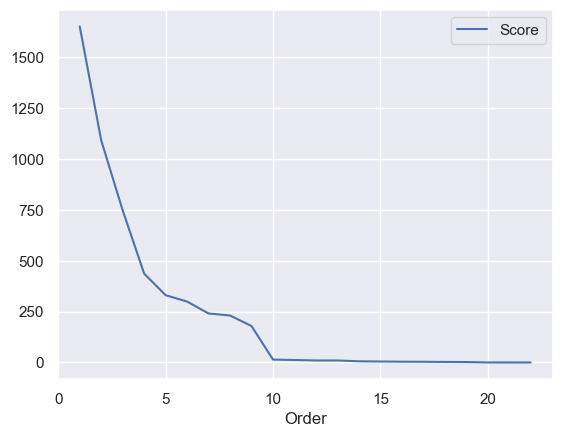

In [57]:
fs_scores_df.sort_values('Score', ascending=False).plot(kind='line', x='Order', y='Score')

In [52]:
fs_df

id     Attrition_Flag  Total_Relationship_Count   
0          0  Existing Customer                         5  \
5          5  Existing Customer                         3   
6          6  Existing Customer                         6   
9          9  Existing Customer                         6   
10        10  Existing Customer                         5   
...      ...                ...                       ...   
10122  10122  Existing Customer                         3   
10123  10123  Attrited Customer                         4   
10124  10124  Attrited Customer                         5   
10125  10125  Attrited Customer                         4   
10126  10126  Attrited Customer                         6   

       Months_Inactive_12_mon  Contacts_Count_12_mon  Total_Revolving_Bal   
0                           1                      3                  777  \
5                           1                      2                 1247   
6                           1                      3                 2264   
9                           3                      3                 1677   
10                          3                      2                 1467   
...                       ...                    ...                  ...   
10122                       2                      3                 1851   
10123                       2                      3                 2186   
10124                       3                      4                    0   
10125                       3                      3                    0   
10126                       2                      4                 1961   

       Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct   
0                     1.335             1144              42  \
5                     1.376             1088              24   
6                     1.975             1330              31   
9                     1.524             1441              32   
10                    0.831             1201              42   
...                     ...              ...             ...   
10122                 0.703            15476             117   
10123                 0.804             8764              69   
10124                 0.819            10291              60   
10125                 0.535             8395              62   
10126                 0.703            10294              61   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0                    1.625                  0.061  
5                    0.846                  0.311  
6                    0.722                  0.066  
9                    0.882                  0.144  
10                   0.680                  0.217  
...                    ...                    ...  
10122                0.857                  0.462  
10123                0.683                  0.511  
10124                0.818                  0.000  
10125                0.722                  0.000  
10126                0.649                  0.189  

[10091 rows x 11 columns]

Data are now preprocessed and can be used to train models.

In [53]:
df.to_csv('data/processed/BankChurners_after_preprocessing.csv', index=False)

In [54]:
fs_df.to_csv('data/processed/BankChurners_after_preprocessing_fs.csv', index=False)


## CHECKPOINT 2

### Model training

In [99]:
df = pd.read_csv('data/processed/BankChurners_after_preprocessing.csv')
# df = pd.read_csv('data/processed/BankChurners_after_preprocessing_fs.csv') # uncomment to run with filtered dataset

In [106]:
RANDOM_STATE = 5
TARGET_COL_NAME = 'Attrition_Flag'

Main metric will be F1 macro since the dataset is imbalanced

In [107]:
def evaluate(truth, prediction, index):
    acc = metrics.accuracy_score(truth, prediction)
    f1 = metrics.f1_score(truth, prediction, average='macro')
    prec = metrics.precision_score(truth, prediction, average='macro')
    rec = metrics.recall_score(truth, prediction, average='macro')

    scores = pd.DataFrame({'F-score': [f1], 'Precision': [prec], 'Accuracy': [acc], 'Recall': [rec]}, index=[index])
    return scores

Encode the category columns as more advanced classification models like Neural Network require that.

In [108]:
df.head()

id  Attrition_Flag  Customer_Age  Dependent_count  Education_Level   
0   0               1            45                3              1.0  \
1   5               1            44                2              3.0   
2   6               1            51                4              3.0   
3   9               1            48                2              3.0   
4  10               1            42                5              0.0   

   Income_Category  Card_Category  Months_on_book  Total_Relationship_Count   
0              2.0            0.0              39                         5  \
1              1.0            0.0              36                         3   
2              4.0            2.0              46                         6   
3              3.0            0.0              36                         6   
4              4.0            0.0              31                         5   

   Months_Inactive_12_mon  ...  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt   
0                       1  ...                 1.335             1144  \
1                       1  ...                 1.376             1088   
2                       1  ...                 1.975             1330   
3                       3  ...                 1.524             1441   
4                       3  ...                 0.831             1201   

   Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  Gender_F   
0              42                1.625                  0.061         0  \
1              24                0.846                  0.311         0   
2              31                0.722                  0.066         0   
3              32                0.882                  0.144         0   
4              42                0.680                  0.217         0   

   Gender_M  Marital_Status_Divorced  Marital_Status_Married   
0         1                        0                       1  \
1         1                        0                       1   
2         1                        0                       1   
3         1                        0                       0   
4         1                        0                       1   

   Marital_Status_Single  
0                      0  
1                      0  
2                      0  
3                      1  
4                      0  

[5 rows x 24 columns]

In [109]:
# Encode the target column
df[TARGET_COL_NAME].replace({'Existing Customer': 1, 'Attrited Customer': 0}, inplace=True)

# Encode boolean columns using astype(int) method (in try catch as there are some columns missing in filtered dataset )
bool_columns = ['Gender_F', 'Gender_M', 'Marital_Status_Divorced', 'Marital_Status_Married', 'Marital_Status_Single']
for bool_column in bool_columns:
    if bool_column in df.columns:
        df[bool_column] = df[bool_column].astype(int)


In [110]:
df.head()

id  Attrition_Flag  Customer_Age  Dependent_count  Education_Level   
0   0               1            45                3              1.0  \
1   5               1            44                2              3.0   
2   6               1            51                4              3.0   
3   9               1            48                2              3.0   
4  10               1            42                5              0.0   

   Income_Category  Card_Category  Months_on_book  Total_Relationship_Count   
0              2.0            0.0              39                         5  \
1              1.0            0.0              36                         3   
2              4.0            2.0              46                         6   
3              3.0            0.0              36                         6   
4              4.0            0.0              31                         5   

   Months_Inactive_12_mon  ...  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt   
0                       1  ...                 1.335             1144  \
1                       1  ...                 1.376             1088   
2                       1  ...                 1.975             1330   
3                       3  ...                 1.524             1441   
4                       3  ...                 0.831             1201   

   Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  Gender_F   
0              42                1.625                  0.061         0  \
1              24                0.846                  0.311         0   
2              31                0.722                  0.066         0   
3              32                0.882                  0.144         0   
4              42                0.680                  0.217         0   

   Gender_M  Marital_Status_Divorced  Marital_Status_Married   
0         1                        0                       1  \
1         1                        0                       1   
2         1                        0                       1   
3         1                        0                       0   
4         1                        0                       1   

   Marital_Status_Single  
0                      0  
1                      0  
2                      0  
3                      1  
4                      0  

[5 rows x 24 columns]

Split the data to training and testing sets

In [111]:
target = df[TARGET_COL_NAME]
df_train = drop_col(df, 'id')
df_train = drop_col(df_train, TARGET_COL_NAME)
X_train, X_test, y_train, y_test = train_test_split(df_train, target, test_size=0.25, random_state=RANDOM_STATE)

### Baseline: Logistic Regression
##### Logistic Regression v1: fitting the model (no oversampling, no hyperparameter tunning)

In our pursuit of finding an appropriate baseline model for our classification task, we carefully considered various options and ultimately decided to employ Logistic Regression. Logistic Regression is a well-established and widely-used statistical technique that is particularly suited for binary classification problems. Its simplicity and interpretability make it an ideal choice for establishing a benchmark performance level. By fitting a logistic regression model to our labeled training data, we can assess its ability to discriminate between the two classes and establish a baseline accuracy for comparison with more advanced algorithms.

In [112]:
model = LogisticRegression(max_iter=5000, tol=0.001)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
y_pred = model.predict(X_test)
rf_scores_test = evaluate(y_test, y_pred, 'logistic_regression_test_v1')

results_df = rf_scores_test
results_df.head()

F-score  Precision  Accuracy    Recall
logistic_regression_test_v1  0.757792   0.807371  0.884661  0.727684

##### Logistic Regression v2: fitting the model (with oversampling, scaling and hyperparameter tunning)

We will try to improve performance of Logistic Regression with help of feature scaling, handle imbalanced data using SMOTE and simple hyperparameter tuning for following parameters:
- C - Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization)
- solver - Algorithm to use in the optimization problem.

In [113]:
# Create custom scoring function
def custom_scoring(estimator, X, y_true):
    y_pred = estimator.predict(X)
    return metrics.f1_score(y_true, y_pred, average='macro')

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Oversampling - imbalanced data handling
smote = SMOTE(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Perform hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg']
}

model = LogisticRegression(max_iter=500, tol=0.001)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=custom_scoring)
grid_search.fit(X_train_balanced, y_train_balanced)
best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(X_test_scaled)
rf_scores_test = evaluate(y_test, y_test_pred, 'logistic_regression_test_v2')

results_df = pd.concat([results_df,rf_scores_test], axis=0)
results_df.head()

F-score  Precision  Accuracy    Recall
logistic_regression_test_v1  0.757792   0.807371  0.884661  0.727684
logistic_regression_test_v2  0.775561   0.744568  0.849386  0.849142

We were able to sligthly improve F-score of Logistic Regression model.

### Multi Layered Perceptron (MLP)

##### MLP v1: fitting the model (with oversampling and scaling)

After using Logistic Regression as a baseline for classification, we opted for a Multi Layered Perceptron (MLP) due to its ability to capture complex relationships in the data. MLP's multi-layer structure and non-linear activation functions enable it to model intricate patterns and extract hierarchical representations, making it a suitable choice for tasks involving non-linear data or high-dimensional datasets. By leveraging MLP's capabilities, we aimed to enhance the model's predictive performance and accommodate the complexities present in our classification problem.

In [114]:
target = df[TARGET_COL_NAME]
df_train = drop_col(df, 'id')
df_train = drop_col(df_train, TARGET_COL_NAME)
X_train, X_test, y_train, y_test = train_test_split(df_train, target, test_size=0.25, random_state=RANDOM_STATE)

model_nnet = MLPClassifier(hidden_layer_sizes=[1],
                           activation='relu',
                           max_iter=200,
                           solver='adam',
                           random_state=42)

model_nnet.fit(X_train_balanced, y_train_balanced)

y_pred_test = model_nnet.predict(X_test_scaled)
rf_scores_test = evaluate(y_test, y_pred_test, 'mlp_test_v1')

results_df = pd.concat([results_df,rf_scores_test], ignore_index=False, sort=False)
results_df.head(10)

F-score  Precision  Accuracy    Recall
logistic_regression_test_v1  0.757792   0.807371  0.884661  0.727684
logistic_regression_test_v2  0.775561   0.744568  0.849386  0.849142
mlp_test_v1                  0.776269   0.745352  0.850575  0.847886

##### MLP v2: fitting the model (with oversampling, scaling and hyperparameter tunning)

Results from MLP strongly depend on the setting of its hyperparameters. Therefore besides scaling (that is also important to apply before training neural networks) and oversampling we will use random search to select best hyperparameters namly:
- hidden_layer_sizes - The ith element represents the number of neurons in the ith hidden layer
- solver - The solver for weight optimization
- alpha - Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
- activation - Activation function for the hidden layer

In [115]:
# Define the parameter grid for random search
param_grid = {
    'hidden_layer_sizes': [[2], [2, 2], [4, 4], [5, 5], [8, 8], [30, 30], [4, 4, 4], [20, 20, 20]],
    'alpha': uniform(loc=0.001, scale=0.1),
    'solver': ['lbfgs', 'sgd', 'adam'],
    'activation': ['logistic', 'relu']
}

model_nnet = MLPClassifier(max_iter=1000, random_state=RANDOM_STATE)

# Perform random search with custom F1 score as the scoring metric, ignore warning that training stopped on max_iter
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    random_search = RandomizedSearchCV(model_nnet, param_distributions=param_grid, n_iter=10, random_state=42,
                                       scoring=custom_scoring)
    random_search.fit(X_train_balanced, y_train_balanced)

# Get the best hyperparameters and evaluate the model
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best F1 Score:", best_score)

Best Hyperparameters: {'activation': 'relu', 'alpha': 0.01006064345328208, 'hidden_layer_sizes': [30, 30], 'solver': 'adam'}
Best F1 Score: 0.9652006658194479


In [116]:
# Get all metrics for model with best hyperparameters
model_nnet = MLPClassifier(hidden_layer_sizes=best_params['hidden_layer_sizes'],
                           alpha=best_params['alpha'],
                           activation=best_params['activation'],
                           max_iter=2500,
                           solver=best_params['solver'],
                           random_state=RANDOM_STATE)
model_nnet.fit(X_train_balanced, y_train_balanced)

y_pred_test = model_nnet.predict(X_test_scaled)
rf_scores_test = evaluate(y_test, y_pred_test, 'mlp_test_v2')

results_df = pd.concat([results_df, rf_scores_test], ignore_index=False, sort=False)
results_df.head(10)

F-score  Precision  Accuracy    Recall
logistic_regression_test_v1  0.757792   0.807371  0.884661  0.727684
logistic_regression_test_v2  0.775561   0.744568  0.849386  0.849142
mlp_test_v1                  0.776269   0.745352  0.850575  0.847886
mlp_test_v2                  0.862125   0.850697  0.922315  0.874990

### Random forest
##### Random forest v1: fitting the model (no oversampling, no hyperparameter tunning)

In [117]:
clf=RandomForestClassifier(random_state=RANDOM_STATE)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
rf_scores_test = evaluate(y_test, y_pred, 'rf_test_v1')

results_df = pd.concat([results_df,rf_scores_test], ignore_index=False, sort=False)
results_df.head(20)

F-score  Precision  Accuracy    Recall
logistic_regression_test_v1  0.757792   0.807371  0.884661  0.727684
logistic_regression_test_v2  0.775561   0.744568  0.849386  0.849142
mlp_test_v1                  0.776269   0.745352  0.850575  0.847886
mlp_test_v2                  0.862125   0.850697  0.922315  0.874990
rf_test_v1                   0.914900   0.934580  0.955608  0.897815

Which features were most important for the model


In [118]:
pd.DataFrame(clf.feature_importances_, index=df_train.columns).sort_values(by=0, ascending=False)

0
Total_Trans_Amt           0.179512
Total_Trans_Ct            0.161107
Total_Ct_Chng_Q4_Q1       0.116584
Total_Revolving_Bal       0.116251
Avg_Utilization_Ratio     0.063675
Total_Relationship_Count  0.060567
Total_Amt_Chng_Q4_Q1      0.056112
Avg_Open_To_Buy           0.033658
Credit_Limit              0.033467
Customer_Age              0.032960
Contacts_Count_12_mon     0.029660
Months_on_book            0.025806
Months_Inactive_12_mon    0.024984
Dependent_count           0.014054
Education_Level           0.011150
Income_Category           0.009731
Gender_M                  0.007260
Gender_F                  0.006912
Marital_Status_Married    0.006161
Marital_Status_Single     0.005382
Card_Category             0.002663
Marital_Status_Divorced   0.002345

##### Random forest v2: fitting the model (with oversampling)

In [119]:
os = SMOTE(random_state=RANDOM_STATE)
columns = X_train.columns
os_train_X, os_train_y = os.fit_resample(X_train, y_train)
os_train_X = pd.DataFrame(data=os_train_X, columns=columns )
os_train_y = pd.DataFrame(data=os_train_y, columns=[TARGET_COL_NAME])

print("Oversampled data length: ",len(os_train_y))
print("Attrited customers proportion: ",len(os_train_y[os_train_y['Attrition_Flag']=='Attrited Customer'])/len(os_train_X))

clf=RandomForestClassifier(random_state=RANDOM_STATE)
clf.fit(os_train_X, os_train_y)

y_pred = clf.predict(X_test)
rf_scores_test = evaluate(y_test, y_pred, 'rf_test_v2')

results_df = pd.concat([results_df,rf_scores_test], ignore_index=False, sort=False)
results_df.head(20)

Oversampled data length:  12706
Attrited customers proportion:  0.0


C:\Users\marti\AppData\Local\Temp\ipykernel_54164\2471879736.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(os_train_X, os_train_y)


F-score  Precision  Accuracy    Recall
logistic_regression_test_v1  0.757792   0.807371  0.884661  0.727684
logistic_regression_test_v2  0.775561   0.744568  0.849386  0.849142
mlp_test_v1                  0.776269   0.745352  0.850575  0.847886
mlp_test_v2                  0.862125   0.850697  0.922315  0.874990
rf_test_v1                   0.914900   0.934580  0.955608  0.897815
rf_test_v2                   0.914424   0.912815  0.953230  0.916053

##### Random forest v3: fitting the model (with oversampling and  hyperparameter tuning)
Our classifier already produces feasible results, however there are some hyperparameters that can be used to train the model.  We haven't taken advantage of those and used the default values.
We are going to use cross-validation implementation - GridSearchCV, which tries all possible combinations of provided hyperparameters values namly:
- max_depth - The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- max_features - The number of features to consider when looking for the best split
- min_samples_leaf - The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
- min_samples_split - The minimum number of samples required to split an internal node.
- n_estimators - The number of trees in the forest.


In [120]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

Commented due to long execution time

In [121]:
# from sklearn.model_selection import GridSearchCV
# # Use the grid search to find the best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier(random_state=RANDOM_STATE)
# rf_gs = GridSearchCV(estimator = rf, param_grid = param_grid,
#                           cv = 5, n_jobs = -1, verbose = 2)
# rf_gs.fit(os_train_X, os_train_y)
# rf_gs.best_params_

The Grid Search cross validation is a very expensive method, therefore we are going to stick with RandomSearchCV which only tries some combinations of hyperparameters.
This way we won't test all the combinations, so we might not be able to find the best one, however the execution time will be shorter.

In [122]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 15, stop = 250, num = 10)]
n_estimators.append(100)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

ccp_alpha = [0.0001, 0]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'ccp_alpha': ccp_alpha}

In [123]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_rs = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='f1_macro', n_iter = 200, cv = 5, verbose=2, random_state=RANDOM_STATE, n_jobs = -1)
rf_rs.fit(os_train_X, os_train_y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\marti\G_DRIVE\skola\sem2\ML\project\venv\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\marti\G_DRIVE\skola\sem2\ML\project\venv\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': [0.0001, 0],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [15, 41, 67, 93, 119,
                                                         145, 171, 197, 223,
                                                         250, 100]},
                   random_state=5, scoring='f1_macro', verbose=2)

In [124]:
y_pred = rf_rs.predict(X_test)
rf_scores_test = evaluate(y_test, y_pred, 'rf_test_v3')

results_df = pd.concat([results_df,rf_scores_test], ignore_index=False, sort=False)
results_df.head(20)

F-score  Precision  Accuracy    Recall
logistic_regression_test_v1  0.757792   0.807371  0.884661  0.727684
logistic_regression_test_v2  0.775561   0.744568  0.849386  0.849142
mlp_test_v1                  0.776269   0.745352  0.850575  0.847886
mlp_test_v2                  0.862125   0.850697  0.922315  0.874990
rf_test_v1                   0.914900   0.934580  0.955608  0.897815
rf_test_v2                   0.914424   0.912815  0.953230  0.916053
rf_test_v3                   0.917321   0.919405  0.955212  0.915271

In [125]:
rf_rs.best_params_

{'n_estimators': 93,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'ccp_alpha': 0,
 'bootstrap': False}

In [126]:
clf=RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=30, bootstrap=False, ccp_alpha=0.0000)
cor_train_X = drop_col(os_train_X, 'Credit_Limit')
cor_train_X = drop_col(cor_train_X, 'Total_Trans_Ct')
# cor_train_X = drop_col(cor_train_X, 'Avg_Open_To_Buy')
clf.fit(cor_train_X, os_train_y)

C:\Users\marti\AppData\Local\Temp\ipykernel_54164\3940352759.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(cor_train_X, os_train_y)


RandomForestClassifier(bootstrap=False, max_depth=30, random_state=5)

The Random Forest classifier has shown superior performance compared to Logistic Regression and Multi-Layer Perceptron on the provided dataset. Random Forest excels in handling complex and high-dimensional data by constructing an ensemble of decision trees and aggregating their predictions. It effectively captures non-linear relationships, interactions, and feature importance, which can be crucial in achieving accurate predictions. Additionally, Random Forest mitigates overfitting by using bootstrap sampling and feature randomization. Also it is commonly used method when we deal with unbalanced data, which is our case.

### Neural Networks with PyTorch

We made the decision to implement our own neural network architecture using PyTorch instead of relying on the multi-layer perceptron (MLP) from the scikit-learn library for several reasons. Firstly, PyTorch provides a more flexible and intuitive framework for building and training neural networks. With PyTorch, we have fine-grained control over the network architecture, allowing us to customize each layer and easily experiment with various activation functions, optimizers, and loss functions. This flexibility is essential when working with complex datasets or tackling challenging tasks. By implementing our own architecture with PyTorch, we can harness the full potential of deep learning techniques and adapt them to our specific needs, ultimately leading to improved performance and more accurate models.

The biggest challenge we encountered with our custom architecture was overfitting, where the model performed exceptionally well on the training data but struggled to generalize to unseen examples. To address this issue, we employed multiple regularization methods to improve the model's generalization ability. 
- Firstly, we applied dropout, which randomly deactivates a certain percentage of neurons during training, forcing the network to rely on different sets of features and preventing over-reliance on specific weights. This technique helps reduce overfitting by promoting model robustness.
- Additionally, we incorporated batch normalization, which normalizes the inputs within each mini-batch during training. This technique helps stabilize and standardize the activations across different layers, making the network less sensitive to parameter initialization and reducing the risk of overfitting.
- To further combat overfitting, we utilized an optimizer with L2 regularization, such as weight decay, which adds a penalty term to the loss function that discourages large weight values. This regularization method helps prevent the model from becoming overly complex by reducing the magnitude of the weights and encourages the network to focus on more important features, leading to improved generalization.
- Lastly, we applied L2 regularization directly to the network's weights themselves. This technique adds a penalty term to the loss function based on the sum of the squared weights, effectively shrinking the weights towards zero and preventing any individual weight from dominating the learning process.

In [129]:
X_train_tensor = torch.Tensor(X_train_balanced)
y_train_tensor = torch.Tensor(y_train_balanced)
X_test_tensor = torch.Tensor(X_test_scaled)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Define our neural network architecture
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.dropout1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.dropout2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

input_size = X_train_tensor.shape[1]
model = NeuralNet(input_size)

# We defined the loss function and optimizer with L2 regularization
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

batch_size = 32
num_epochs = 20
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
test_losses = []

# Start training
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_inputs, batch_labels in train_data_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels.view(-1, 1))
        
        # L2 regularization
        l2_lambda = 0.001
        l2_regularization = torch.tensor(0.)
        for param in model.parameters():
            l2_regularization += torch.norm(param, 2)
        loss += l2_lambda * l2_regularization
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_inputs.size(0)
    
    # Update the learning rate as we made its value dynamic
    scheduler.step(running_loss)
    
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    
    # Evaluate the model on the test data
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test.view(-1, 1))
        test_losses.append(test_loss.item())
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss}, Test Loss: {test_loss.item()}")


# Vizualization
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Get predictions on unseed data
with torch.no_grad():
    model.eval()
    predicted_probs = model(X_test_tensor)

# Convert probabilities to binary predictions
predicted_labels = (predicted_probs >= 0.5).float().squeeze().numpy()

TypeError: Series.view() takes from 1 to 2 positional arguments but 3 were given

From this graph we can clearly see if the model will be overfitting, test loss would be increasing and train loss decreasing. If we add more epochs we would be still able to observe this so in that case there is possibility to add more regularization or make architecture more simple.

In [130]:
y_test_np = y_test.numpy()

rf_scores_test = evaluate(y_test_np, predicted_labels, 'custom_NN_test')
results_df = pd.concat([results_df,rf_scores_test], ignore_index=False, sort=False)
results_df.head(20)

AttributeError: 'Series' object has no attribute 'numpy'